# Projet de machine learning : D√©tection de transactions frauduleuses


- DIARRASSOUBA Sakaria

Janvier 2020

Dans le cadre de ce projet de machine learning, nous avons souhait√© travailler sur la d√©tection de transactions frauduleuses en ligne. L'objectif de ce notebook est de pr√©senter le travail que nous avons effectu√© : les diff√©rents algorithmes que nous avons impl√©ment√©s ainsi que les reflexions men√©es. Pour cela, dans une premi√®re partie nous pr√©senterons : la probl√©matique de ce projet ainsi que la base de donn√©es et les diff√©rents traitements effectu√©es sur celle-ci. Ensuite, dans un second temps nous d√©taillerons les diff√©rents algorithmes test√©s. Enfin, nous comparerons ces derniers et √©voquerons les difficult√©s rencontr√©es et les pistes d'am√©lioration possibles. 

## Sommaire :
- I- Probl√©matique et base de donn√©es 
- II- Arbre de d√©cision
- III- Random Forest
- IV- R√©seau de neurones
- V- Gradient Boosting
- VI- Support Vector Machine
- VII- Conclusion 

# I- Probl√©matique et base de donn√©es 

Nous avons choisi d'utiliser une base de donn√©es libre de droits qui fait l'objet d'une [comp√©tition Kaggle](https://www.kaggle.com/c/ieee-fraud-detection/data). Celle-ci est propos√©e par l'institut IEEE Computational Intelligence Society (IEEE-CIS) qui travaille sur divers sujets de machine learning et la soci√©t√© de services de paiement Vesta. Les donn√©es sont constitu√©es de transactions de commerce √©lectronique de Vesta et contiennent diff√©rentes caract√©ristiques telles que le type d'appareil de paiement ou les caract√©ristiques du produit achet√©. Pour chaque transaction nous disposons d'une variable nomm√©e "isFraud" qui vaut 1 si la transaction est frauduleuse et 0 sinon.   
Les tables de donn√©es d'entrainement et de test sont chacunes divis√©es en deux fichiers :

- train_transaction.csv et test_transaction.csv : qui correspondent aux informations sur chaque transaction : le fait qu'elle soit frauduleuse, le type de produit achet√©, le montant de la transaction, les informations sur la carte de paiement etc. 


- train_identity.csv et test_identity.csv : les variables de ces tables sont les informations d'identit√© : informations de connexion r√©seau (IP, FAI, proxy, etc.), signature num√©rique (UA/navigateur/os/version, etc.) associ√©es au client qui a effectu√© les transactions. Elles sont recueillies par le syst√®me de protection contre la fraude de Vesta et ses partenaires de s√©curit√© num√©rique. Pour des raisons de protection des donn√©es priv√©es les noms des champs sont masqu√©s.

Ces deux fichiers sont joints par la variable "TransactionID" qui repr√©sente l'ID unique d'une transaction. Par ailleurs, les transactions n'ont pas toutes les informations d'identit√© correspondantes.


Probl√©matique : l'objectif est de pr√©dire √† partir des informations dont nous disposons pour chaque transaction si elle est frauduleuse ou non. Il s'agit donc d'un probl√®me de classification supervis√©e √† deux classes.

## I- 0. Import des biblioth√®ques

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## I- 1. Chargement des bases de donn√©es

### Base de donn√©es d'entrainement

La base de donn√©es d'entrainement identity est constitu√©e de 144233 identit√©s et 41 variables num√©riques et cat√©gorielles. 
La base de donn√©es d'entrainement transaction est constitu√©e de 590540 transactions et 394 variables num√©riques et cat√©gorielles.

In [3]:
%%time
train_identity=pd.read_csv("datasets/train_identity.csv")
train_transaction=pd.read_csv("datasets/train_transaction.csv")

CPU times: user 21.7 s, sys: 7.14 s, total: 28.8 s
Wall time: 29.1 s


In [4]:
print(train_identity.shape)
train_identity.head()

(144233, 41)


TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [5]:
print(train_transaction.shape)
train_transaction.head()

(590540, 394)


TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

Nous effectuons la jointure des deux tables sur la variable commune : TransactionID

In [6]:
%%time
#Jointure
train_dataset = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

#Suppression base de donn√©es inutiles
del train_transaction, train_identity

CPU times: user 6.91 s, sys: 7.3 s, total: 14.2 s
Wall time: 16.4 s


In [7]:
print(train_dataset.shape)
train_dataset.head()

(590540, 434)


TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

### Probl√®me de classification binaire d√©s√©quilibr√©e

Text(0.5, 1.0, "R√©partition de la variable 'isFraud'")

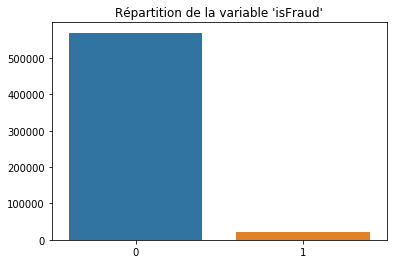

In [8]:
x = train_dataset['isFraud'].value_counts().values
sns.barplot([0,1], x)
plt.title("R√©partition de la variable 'isFraud'")

In [9]:
print("La part de transactions frauduleuses dans la base de donn√©es d'entrainement est de ",round(len(train_dataset['isFraud'][train_dataset['isFraud']==1])/ len(train_dataset['isFraud'])*100,2),'%')

La part de transactions frauduleuses dans la base de donn√©es d'entrainement est de  3.5 %


Ainsi, nous constatons que la part de donn√©es frauduleuses est tr√®s faible. Nous sommes face √† un probl√®me de classes d√©s√©quilibr√©es. En effet, l'√©v√©nement que nous souhaitons pr√©dire est tr√®s peu observ√©. Il existe donc un risque de cr√©er des mod√®les qui pr√©disent toujours la classe majoritaire (ie la transaction est non frauduleuse). Nous devons donc tenir compte de cette probl√®matique dans l'impl√©mentation des algorithmes. De plus, les outils choisis pour mesurer l'efficacit√© des mod√®les et les comparer entre eux doivent √©galement tenir compte de cet aspect. Le crit√®re habituellement choisi : la pr√©cision (c'est-√†-dire le taux de pr√©diction correctement identifi√©es) peut nous donner une vision biais√©e. La part de transactions frauduleuses √©tant tr√®s faible, nous pouvons obtenir une pr√©cision tr√®s √©lev√©e en classant la grande majorit√© des transactions comme non frauduleuses. Cependant, l'objectif est au contraire de r√©ussir √† pr√©dire les fraudes. Il est donc n√©cessaire d'introduire d'autres moyens de mesure de l'efficacit√©. Nous avons choisi le crit√®re de l'aire sous la courbe ROC. Nous nous baserons sur celui-ci pour comparer les diff√©rents mod√®les cr√©√©s par la suite. 


#### Rappel sur la courbe ROC et l'aire sous la courbe 

L‚Äôobjectif de la courbe ROC est de faire varier le seuil (fix√© √† 0.5 en g√©n√©ral) qui permet d‚Äôaffecter √† chaque observation une pr√©diction (classe n√©gative ou positive) entre 0 et 1. Pour chaque valeur du seuil on calcule la sensibilit√© et la sp√©cificit√© avec :

- La sensibilit√© : repr√©sente parmi toutes les √©tiquettes positives la part des √©tiquettes correctement identifi√©es, ie $$Sensibilit√© = \frac{VP}{VP+ FN}$$ 
- $$ 1‚àíSp√©cificit√© =\frac{FP}{FP+VN} $$

(o√π VP = Vrai Positif = label ‚Äò1‚Äô correctement pr√©dit,
    VN = Vrai N√©gatif = label ‚Äò0‚Äô correctement pr√©dit,
    FP = Faux Positif = label ‚Äò1‚Äô mal pr√©dit,
    FN = Faux N√©gatif = label ‚Äò0‚Äô mal pr√©dit)
    
Pour un mod√®le parfait, on obtient des valeurs de sensibilit√© et sp√©cificit√© √©gales √† 1. La courbe ROC permet de voir comment la sp√©cificit√© et la sensibilit√© varient en fonction du seuil. Elle repr√©sente la sensibilit√© en fonction de 1 ‚Äì la sp√©cificit√©, c‚Äôest-√†-dire la proportion de vrais positifs en fonction de la proportion des faux positifs pour diff√©rentes valeurs du seuil. Pour obtenir le meilleur seuil, l‚Äôid√©al serait d‚Äôobtenir une sensibilit√© et une sp√©cificit√© √©gales √† 1 (c‚Äôest-√†-dire un taux de faux positifs = 0 et un taux de vrais positifs = 1). Ce n‚Äôest g√©n√©ralement pas possible et il faut tenter d‚Äôobtenir les plus fortes valeurs pour ces deux param√®tres, sachant qu‚Äôils varient en sens inverse.


L'Aire sous la courbe ROC (AUC : Area Under the Curve) fournit une mesure agr√©g√©e des performances pour tous les seuils de classification possibles. Les valeurs d'AUC sont comprises dans une plage de 0 √† 1. Un mod√®le dont 100 % des pr√©dictions sont erron√©es a une AUC de 0. Si toutes ses pr√©dictions sont correctes, l‚ÄôAUC est de 1. L'objectif est donc d'obtenir une AUC la plus √©lev√©e possible.

### Base de donn√©es test

Les donn√©es √©tant issues d'une ancienne comp√©tition propos√©e par Kaggle, la base de donn√©es de test ne contient pas la variable "isFraud".
Afin de conna√Ætre le score r√©alis√© il faut envoyer un fichier au m√™me format que "sample_submission" 

In [10]:
%%time
test_identity=pd.read_csv('datasets/test_identity.csv')
test_transaction=pd.read_csv('datasets/test_transaction.csv')

CPU times: user 18.9 s, sys: 3.68 s, total: 22.5 s
Wall time: 22.2 s


In [11]:
print(test_identity.shape)
test_identity.head()

(141907, 41)


TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   
2        3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN    NaN   
3        3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    NaN    NaN   
4        3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN    NaN   

   id_09  ...                    id_31  id_32     id_33           id_34  \
0    NaN  ...  chrome 67.0 for android    NaN       NaN             NaN   
1    0.0  ...  chrome 67.0 for android   24.0  1280x720  match_status:2   
2    NaN  ...       ie 11.0 for tablet    NaN       NaN             NaN   
3    0.0  ...  chrome 67.0 for android    NaN       NaN             NaN   
4    NaN  ...  chrome 67.0 for android    NaN       NaN             NaN   

   id_35 id_36 id_37  id_38  DeviceType                   DeviceInfo  
0      F     F     T      F      mobile  MYA-L13 Build/HUAWEIMYA-L13  
1      T     F     T      T      mobile         LGLS676 Build/MXB48T  
2      F     T     T      F     desktop                  Trident/7.0  
3      F     F     T      F      mobile  MYA-L13 Build/HUAWEIMYA-L13  
4      F     F     T      F      mobile         SM-G9650 Build/R16NW  

[5 rows x 41 columns]

In [12]:
print(test_transaction.shape)
test_transaction.head()

(506691, 393)


TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6  ...  V330  V331  V332  V333 V334 V335  \
0  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
1  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
2  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
3  150.0        visa  166.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
4  150.0  mastercard  117.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   

   V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN  

[5 rows x 393 columns]

In [13]:
%%time
#Jointure
test_dataset = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
print(test_dataset.shape)

#Suppression base de donn√©es inutiles
del test_transaction, test_identity

(506691, 433)
CPU times: user 5.73 s, sys: 5.4 s, total: 11.1 s
Wall time: 11.8 s


In [14]:
test_dataset.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6  ...  id_31  id_32  id_33  id_34 id_35  \
0  150.0        visa  226.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
1  150.0        visa  226.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
2  150.0        visa  226.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
3  150.0        visa  166.0  debit  ...    NaN    NaN    NaN    NaN   NaN   
4  150.0  mastercard  117.0  debit  ...    NaN    NaN    NaN    NaN   NaN   

  id_36  id_37  id_38  DeviceType  DeviceInfo  
0   NaN    NaN    NaN         NaN         NaN  
1   NaN    NaN    NaN         NaN         NaN  
2   NaN    NaN    NaN         NaN         NaN  
3   NaN    NaN    NaN         NaN         NaN  
4   NaN    NaN    NaN         NaN         NaN  

[5 rows x 433 columns]

## I-2 Traitement des donn√©es 

La base de donn√©es √©tant volumineuse on peut commencer par all√©ger l'espace allou√© en modifiant le type des variables, sans perte d'informations

In [15]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [16]:
%%time
train_dataset = reduce_mem_usage(train_dataset, verbose=True)
test_dataset = reduce_mem_usage(test_dataset, verbose=True)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)
CPU times: user 4min 53s, sys: 4min 47s, total: 9min 41s
Wall time: 5min 18s


Par ailleurs, nous constatons que les variables nomm√©es id_xx dans la base d'entrainement sont nomm√©es id-xx dans la base test. Nous cr√©ons donc une fonction pour que les variables aient le m√™me nom dans chacune des bases.

In [17]:
%%time
def modifColumnName(train, test, target="isFraud"):
    """
    modifie le nom des colonnes id-xx de la base test en id_xx
    """
    col_X = [col for col in train.columns if col not in [target]]
    bad_written_features_test = set(test.columns).difference(set(col_X))
    for col in test.columns:
        if col in bad_written_features_test:
            test[col[0:2]+"_"+col[3:5]] = test[col]
            del test[col]
    return test

test_dataset = modifColumnName(train=train_dataset, test=test_dataset)

CPU times: user 900 ¬µs, sys: 175 ¬µs, total: 1.08 ms
Wall time: 541 ¬µs


### Suppression des variables avec un nombre de valeurs manquantes trop important

La base de donn√©es que nous avons choisie contient des donn√©es manquantes. Tout d'abord nous allons observer la proportion de valeurs manquantes pour chaque variable. Ainsi, nous d√©cidons que si certaines variables poss√®dent trop de valeurs manquantes (nous fixons un seuil) nous les supprimons.

In [18]:
# Proportion des donn√©es manquantes pour chaque variable
train_data_null = train_dataset.isna().sum()/len(train_dataset) * 100
train_data_null.head(15)

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              1.512683
card3              0.265012
card4              0.267044
card5              0.721204
card6              0.266028
addr1             11.126427
addr2             11.126427
dist1             59.652352
dist2             93.628374
dtype: float64

Nous affichons sous forme de barplot la proportion de valeurs non manquantes pour chaque variables :

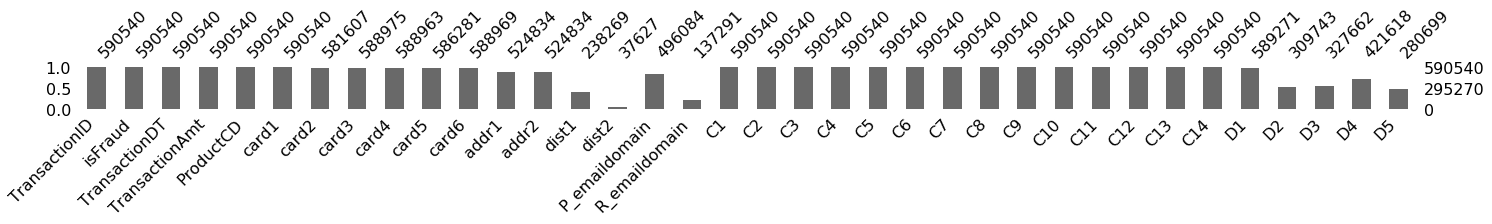

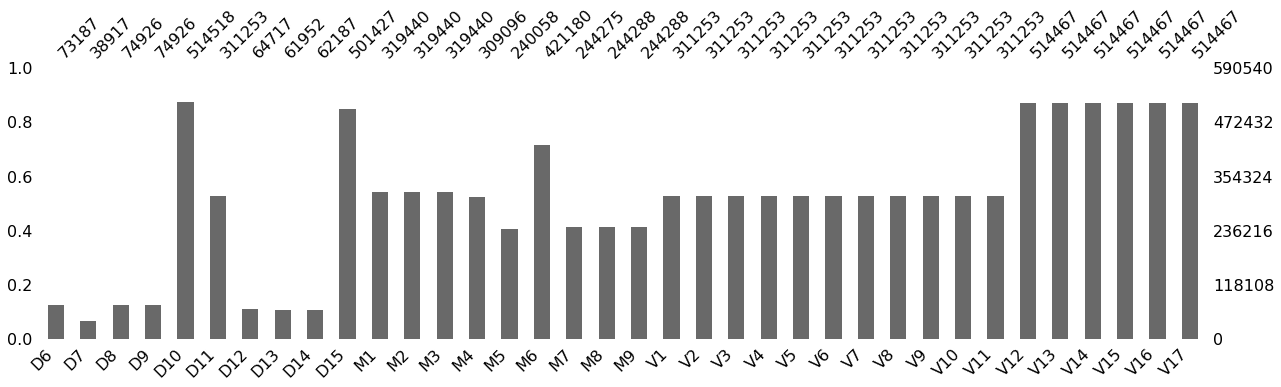

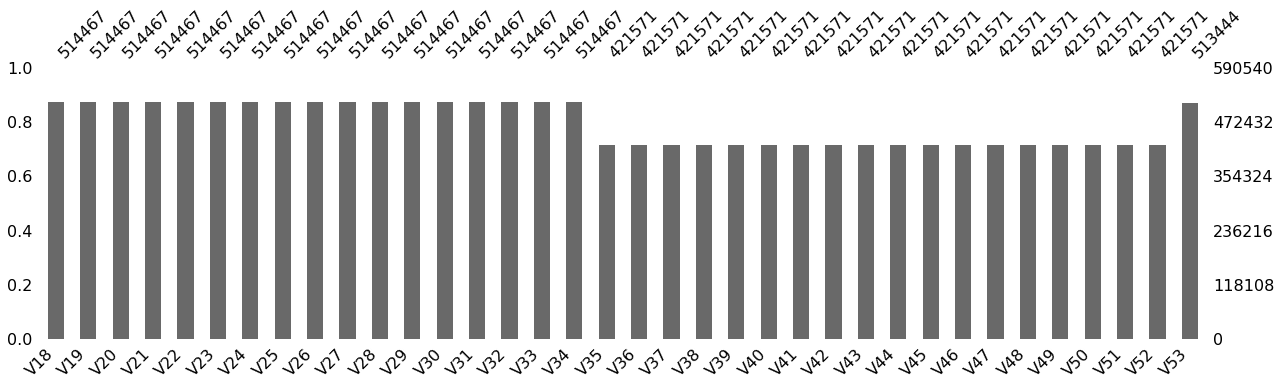

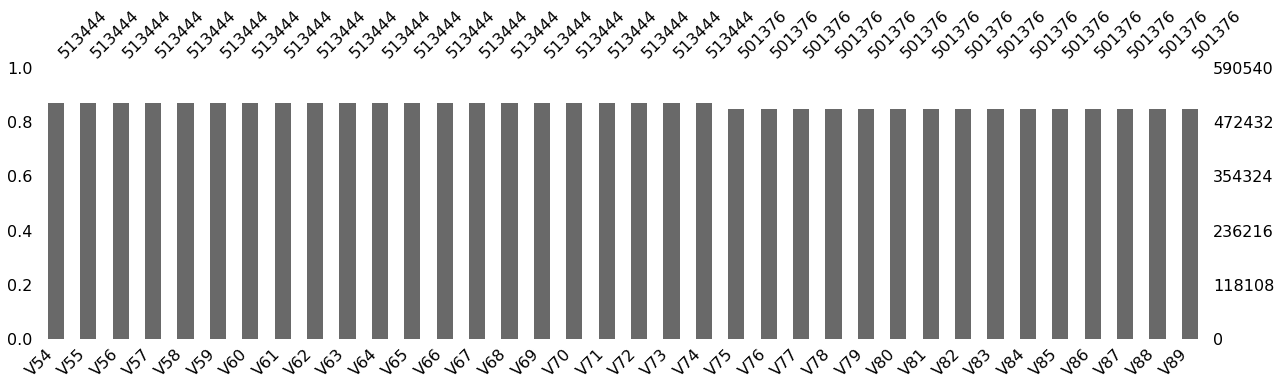

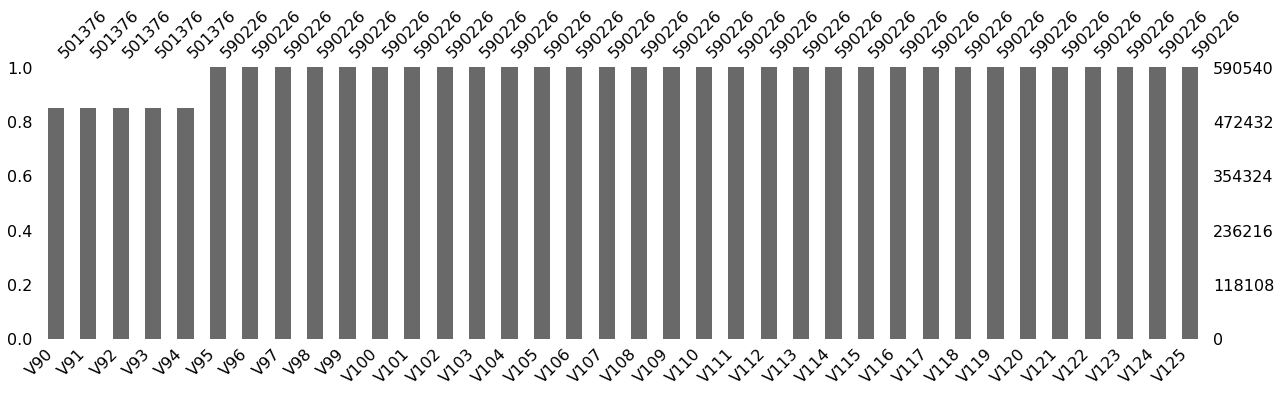

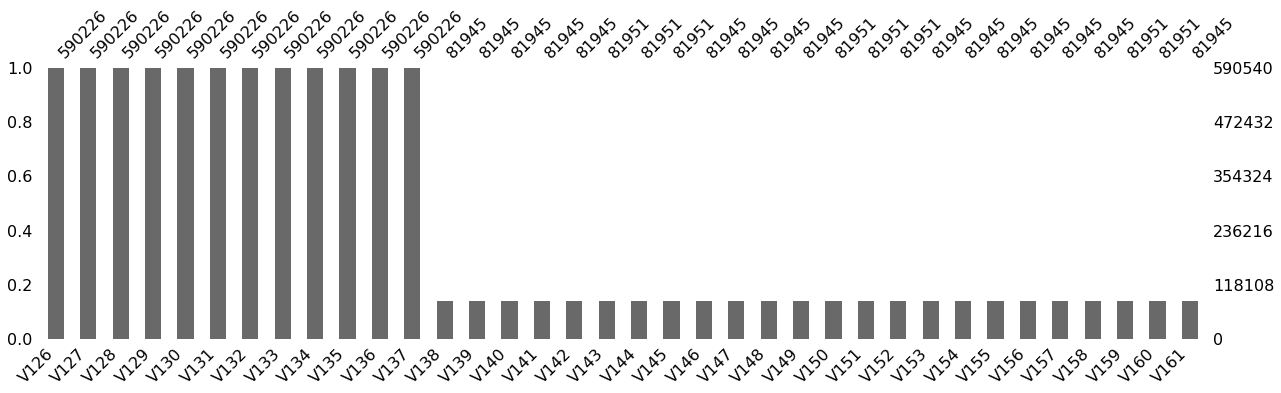

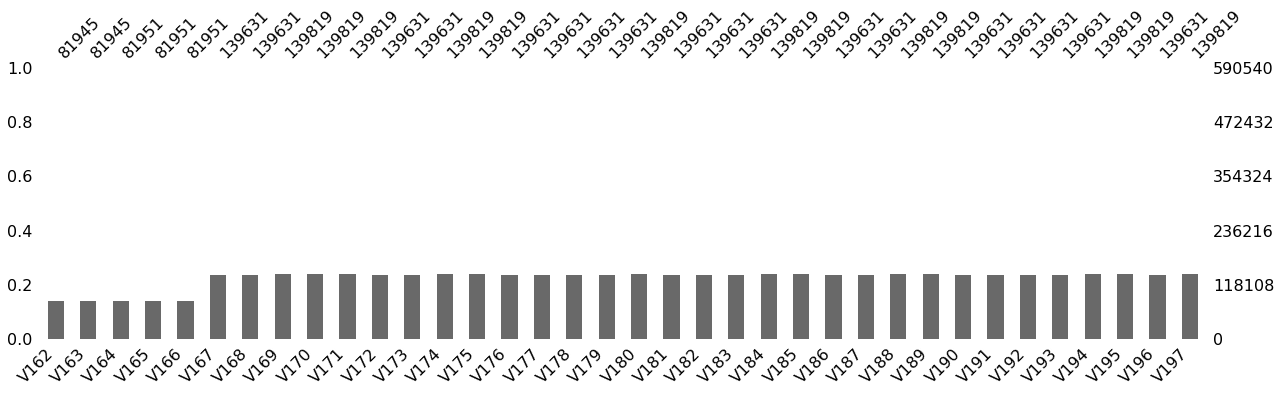

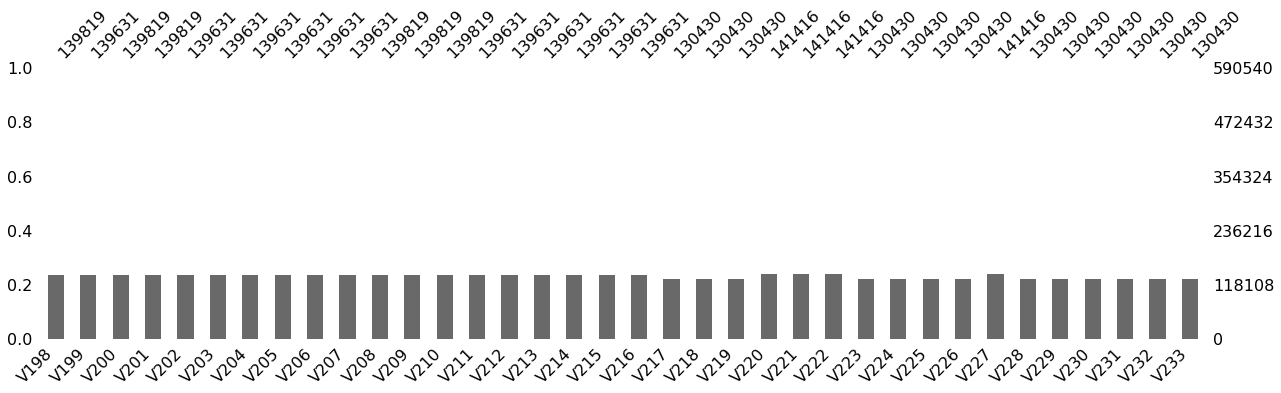

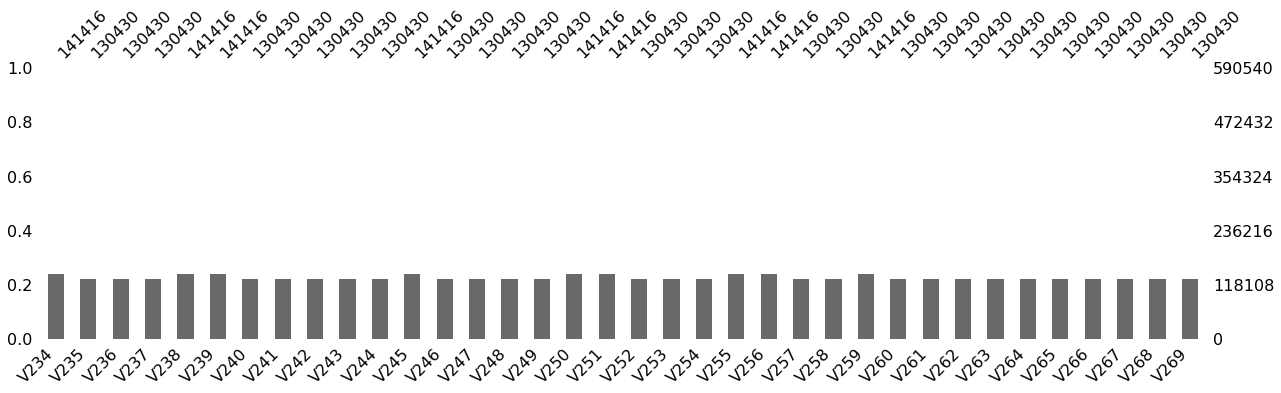

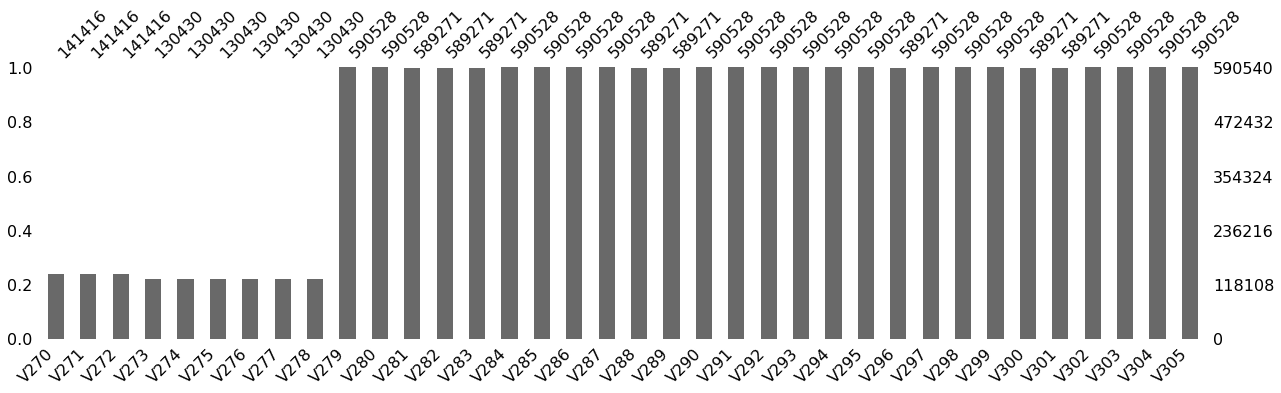

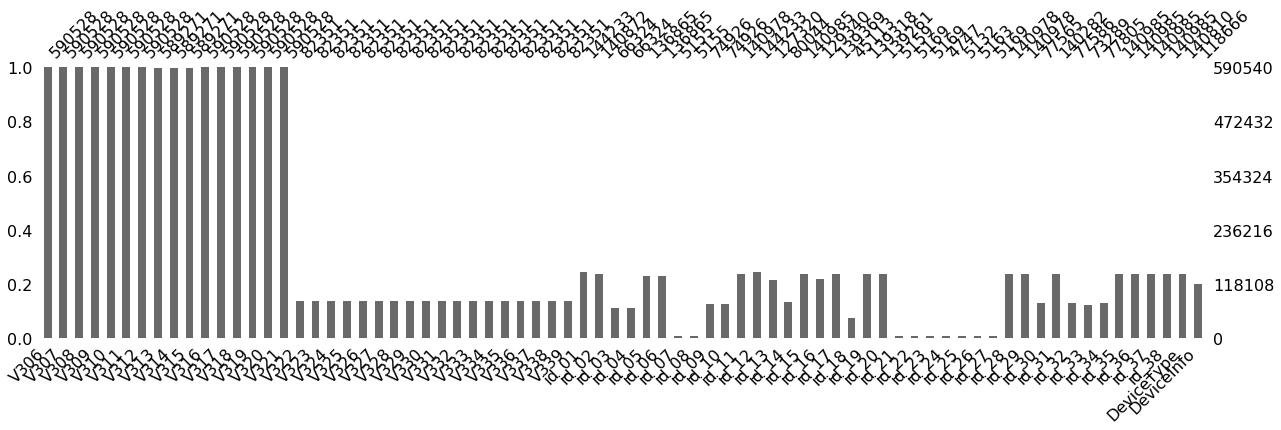

In [19]:
# Programme pour visualiser les valeurs manquantes dans la base de donn√©es 
import missingno as msno

feature=list(train_dataset.columns)
for i in range(10):
    plt.subplot(11,1,i+1)
    msno.bar(train_dataset[feature[36*i:36*i+36]].copy(),labels=True)
    plt.show()
    plt.subplots_adjust(bottom=0.1, right=0.8, top=5)

plt.subplot(11,1,11)
msno.bar(train_dataset[feature[360:]].copy(),labels=True)
plt.show()

Nous d√©cidons de supprimer toutes les variables qui contiennent plus de 50% de variables manquantes 

In [20]:
%%time
taux = .5
train_dataset = train_dataset.dropna(thresh=int(train_dataset.shape[0]*taux), axis=1)
feat_after = [col for col in train_dataset.columns if col not in ["isFraud"]]
#Nous supprimons les m√™mes colonnes dans la base test
test_dataset = test_dataset[feat_after]
print(test_dataset.shape)

(506691, 219)
CPU times: user 4.31 s, sys: 2 s, total: 6.32 s
Wall time: 5.99 s


Ainsi, sur les 434 variables dont nous disposions au d√©but nous n'en gardons que 220.

### Traitement des valeurs manquantes

M√™me si nous avons supprim√© une partie des variables qui contenaient un nombre trop important de valeurs manquantes, il manque encore certaines valeurs. Nous allons donc impl√©menter diff√©rentes techniques pour remplacer ces valeurs afin de pouvoir tester par la suite les diff√©rents algorithmes de classification.

Tout d'abord, nous s√©parons les variables cat√©goriques des variables num√©riques :

In [21]:
# voir les types des variables
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 220 entries, TransactionID to V321
dtypes: float16(189), float32(18), int16(1), int32(2), int8(1), object(9)
memory usage: 304.7+ MB


In [22]:
%%time
features = [col for col in train_dataset.columns if col not in ["isFraud", "TransactionID"]]

num_feat = train_dataset[features].select_dtypes(include=['float16', 'float32','int16','int32']).columns.to_list()
cat_feat = train_dataset[features].select_dtypes(exclude=['float16', 'float32','int16','int32']).columns.to_list()

CPU times: user 1.59 s, sys: 774 ms, total: 2.37 s
Wall time: 1.36 s


#### Variables num√©riques

Nous d√©cidons de remplacer les valeurs manquantes num√©riques par la moyenne de chaque variable. C'est une technique relativement simple et il existe d'autres techniques plus avanc√©es que nous n'utiliserons pas dans le cadre de ce projet.

In [23]:
#%%time
def impute_numeric(data, feat):
    """
    Remplace les valeurs manquantes par la moyenne
    """
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", fill_value=None,
                            verbose=0, copy=True, add_indicator=False)
    X = pd.DataFrame(imputer.fit_transform(data[feat].values), columns=feat)
    return X    

X_train_num = impute_numeric(data=train_dataset, feat=num_feat)
X_test_num = impute_numeric(data=test_dataset, feat=num_feat)

#### Variables cat√©gorielles

Tout d'abord nous devons d√©cider d'une m√©thode pour remplacer les valeurs manquantes. Nous s√©l√©ctionnons deux m√©thodes : 
- Nous rempla√ßons les valeurs manquantes par la modalit√© la plus repr√©sent√©e 
- Nous cr√©ons une modalit√© Other pour les valeurs manquantes.

Ensuite, nous devons transformer les variables cat√©gorielles afin qu'elles puissent √™tre utilis√©es par nos algorithmes. Pour cela on dispose de plusieurs m√©thodes :
- OneHotEncoding (variables dummies) : pour chaque variable cat√©gorielle nous cr√©ons une colonne par modalit√©. Cela implique un grand nombre de colonnes si les variables poss√®dent beaucoup de modalit√©s.
- LabelEncoder : nous ne cr√©ons pas de nouvelle colonne, chaque modalit√© est transform√©e en une valeur enti√®re. Cela limite donc le nombre de modalit√©s.


In [24]:
%%time
def impute_categorical(train, test, categorical_features, method, filling_method, n_values=50):
    
    train_cat = train[categorical_features].astype(str)
    test_cat = test[categorical_features].astype(str)

    for col in categorical_features:

        print("Filling nan "+str(col)+" ... ")
        
        # VALEURS MANQUANTES
        if filling_method == 'mostFqz':
            value = train[col].value_counts().index[0] #va remplacer le NaN
            train_cat[col] = train[col].apply(lambda x: value if pd.isnull(x) else x)
            test_cat[col] = test[col].apply(lambda x: value if pd.isnull(x) else x)
        else:
            train_cat[col] = train[col].apply(lambda x: 'Other' if pd.isnull(x) else x)
            test_cat[col] = test[col].apply(lambda x: 'Other' if pd.isnull(x) else x)

        # TRANSFORMATION DES VARIABLES
        
        if method == 'LE':

            print("~~~ LabelEncoding "+str(col)+" ... ")

            LE = LabelEncoder()
            tab = pd.concat([train_cat[col], test_cat[col]], axis=0)
            LE.fit(tab)
            #certaines modalit√©s n'apparaissent que dans test et g√©n√®re des erreurs
            train_cat[col] = LE.transform(train_cat[col])
            test_cat[col] = LE.transform(test_cat[col])
            
    if method == 'OHE':

        print("~~~ OneHotEncoding ... ")

        categories = []

        # Nombre trop important de modalit√© sur certaines variables ==> Memory Error donc limitation √†
        # 'n_values' modalit√©s
        for column in categorical_features:

            print(("Recovery of the most frequent modalities for "+str(column)+" ... "))
            categories.append(list(train_cat[column].value_counts().iloc[: n_values - 1].index) + ['Others'])
            values2use = categories[-1]
            train_cat[column] = train_cat[column].apply(lambda x: x if x in values2use else 'Others')
            test_cat[column] = test_cat[column].apply(lambda x: x if x in values2use else 'Others')
            
        OHE = OneHotEncoder(categories=categories)
        OHE.fit(train_cat)
        train_cat = pd.DataFrame(OHE.transform(train_cat).toarray().astype(np.int8),
                                      columns=OHE.get_feature_names(categorical_features), dtype=int)
        test_cat = pd.DataFrame(OHE.transform(test_cat).toarray().astype(np.int8),
                                      columns=OHE.get_feature_names(categorical_features), dtype=int)
    print(" ... End ")

    return train_cat, test_cat

bd = impute_categorical(train=train_dataset,
                        test=test_dataset,
                        categorical_features=cat_feat,
                        method="LE", #OHE : OneHotEncoder / LE : LabelEncoder
                        filling_method=None) #mostFqz : valeur la plus fr√©quente / None : cr√©er une cat√©gorie √† part

X_train_cat, X_test_cat = bd[0], bd[1]
del bd

Filling nan ProductCD ... 
~~~ LabelEncoding ProductCD ... 
Filling nan card4 ... 
~~~ LabelEncoding card4 ... 
Filling nan card6 ... 
~~~ LabelEncoding card6 ... 
Filling nan P_emaildomain ... 
~~~ LabelEncoding P_emaildomain ... 
Filling nan M1 ... 
~~~ LabelEncoding M1 ... 
Filling nan M2 ... 
~~~ LabelEncoding M2 ... 
Filling nan M3 ... 
~~~ LabelEncoding M3 ... 
Filling nan M4 ... 
~~~ LabelEncoding M4 ... 
Filling nan M6 ... 
~~~ LabelEncoding M6 ... 
 ... End 
CPU times: user 14.9 s, sys: 681 ms, total: 15.6 s
Wall time: 12.9 s


In [25]:
Train = pd.concat([train_dataset[["isFraud", "TransactionID"]], X_train_num, X_train_cat], axis=1)
Test = pd.concat([test_dataset["TransactionID"], X_test_num, X_test_cat],axis=1)

target = "isFraud"
col_X = [col for col in Train.columns if col not in target]

del train_dataset, test_dataset, X_train_num, X_train_cat, X_test_num, X_test_cat

print("Shape Train :", Train.shape)
print("Shape Test :", Test.shape)

Shape Train : (590540, 220)
Shape Test : (506691, 219)


Nous d√©cidons √©galement mettre les variables num√©riques √† la m√™me echelle 

In [26]:
%%time
from sklearn.preprocessing import MinMaxScaler

mn = MinMaxScaler(feature_range=(0, 1), copy=False)
Train[num_feat] = pd.DataFrame(mn.fit_transform(Train[num_feat]), columns=num_feat)
Test[num_feat] = pd.DataFrame(mn.transform(Test[num_feat]), columns=num_feat)

CPU times: user 4.49 s, sys: 802 ms, total: 5.29 s
Wall time: 4.13 s


## I-3 S√©paration des donn√©es : train et validation

Nous s√©parons la base d'entrainement en deux : base d'entrainement et base de validation. Nous utilisons 20% de la base d'entrainement pour cr√©er la base de validation

In [27]:
pct=0.2
X_tr, X_val, y_tr, y_val = train_test_split(Train[col_X], Train[target], test_size=pct, random_state=42)

In [27]:
print("len of X_train=",len(X_tr))
print("len of X_validation=",len(X_val))

len of X_train= 472432
len of X_validation= 118108


## I-4 Techniques d'√©chantillonnage pour la classification binaire d√©s√©quilibr√©e

Pour trouver des solutions au probl√®me de classification binaire d√©s√©quilibr√©e, nous proposons deux techniques d'√©chantillonnage sur nos donn√©es d'entrainement. Ainsi, nous pourrons tester ces m√©thodes sur nos algorithmes.

### Under sampling

La m√©thode d'under sampling consiste √† r√©duire le nombre d'observations de la classe majoritaire afin d'obtenir une part √©quivalente de donn√©es issues de la classe positive et de la classe n√©gative. Cela implique donc une perte d'information dans la mesure o√π nous supprimons une partie des donn√©es.

In [30]:
from imblearn.under_sampling import RandomUnderSampler

ran=RandomUnderSampler() 
X_rs,y_rs = ran.fit_sample(X_tr, y_tr)

Using TensorFlow backend.
/Users/raphaelmignot/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/raphaelmignot/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/raphaelmignot/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/raphaelmignot/anaconda3/l

Text(0.5, 1.0, "R√©partition de la variable 'isFraud'")

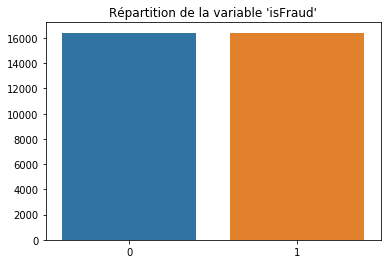

In [33]:
x = np.array([len(y_rs[y_rs==0]),len(y_rs[y_rs==1])])
sns.barplot([0,1], x)
plt.title("R√©partition de la variable 'isFraud'")

In [34]:
X_rs.shape

(32842, 219)

Nous constatons ici que nous perdons beaucoup de donn√©es : nous passons de 472432 √† 32842 observations.

### Over sampling

La m√©thode d'over sampling consiste √† dupliquer al√©atoirement des donn√©es issues de la classe positive afin d‚Äôatteindre une proportion √©quivalente de donn√©es de la classe positive et n√©gative. N√©anmoins cela peut √™tre risqu√© car il peut y avoir un sur apprentissage du mod√®le

In [35]:
from imblearn.over_sampling import RandomOverSampler

ran=RandomOverSampler()
X_ran,y_ran= ran.fit_resample(X_tr,y_tr)


Text(0.5, 1.0, "R√©partition de la variable 'isFraud'")

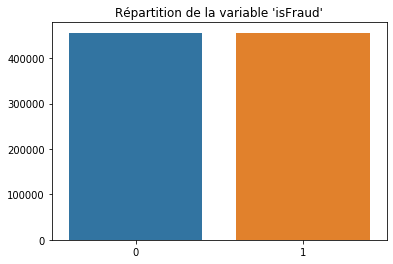

In [36]:
x = np.array([len(y_ran[y_ran==0]),len(y_ran[y_ran==1])])
sns.barplot([0,1], x)
plt.title("R√©partition de la variable 'isFraud'")

# II- Arbre de d√©cision

Les arbres de d√©cision sont des algorithmes d'apprentissage utilis√©s √† la fois pour la regression et la classification supervis√©e. Ici, nous allons les utiliser dans le cadre de notre probl√®me de classification binaire supervis√©e. Nous allons utiliser l'algorithme de CART.

D'apr√®s le cours, nous savons qu'un arbre de d√©cision consiste √† d√©composer le probl√®me de classification en une suite de tests simples qui partitionne l'espace des donn√©es (not√© ici $\{\mathcal X\}$) en sous r√©gions homog√®nes. Chaque noeud de l'arbre correspond √† une r√®gle.

A chaque √©tape de l'algorithme d'apprentissage :
- On consid√®re la partiton  $\mathcal P = \{\mathcal X\}$;
- Pour chaque √©l√©ment $\mathcal A$ de $\mathcal P$ on d√©finit la sous partition $\mathcal A = \mathcal L_{j, \tau} \cup \mathcal R_{j, \tau}$ o√π  $j$ est l'index de la variable et $\tau \in \mathbb R$ un seuil et

\begin{cases}
        \mathcal L_{j, \tau} = \left\{ x \in \mathcal A :  x_j \le \tau \right\}\\
        \mathcal R_{j, \tau} = \left\{ x \in \mathcal A :  x_j > \tau \right\}
        %= \mathcal A \backslash \mathcal L_{j, \tau}.
\end{cases}

sont les parties droite et gauche de $\mathcal A$. Ensuite les meilleures paires variables et seuils sont trouv√©es :
$$
    (j, \tau) \in \operatorname{arg\,min}_{1 \le j \le d \atop \tau \in \mathbb R}
    \frac{\left| \mathcal L_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal L_{j, \tau}) +
    \frac{\left| \mathcal R_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal R_{j, \tau})
$$
o√π $D$ est une mesure d'impuret√©.
- On remplace $\mathcal A$ par $\mathcal L_{j, \tau}$ et $\mathcal R_{j, \tau}$ dans la partition $\mathcal P$;
- On recommence √† partir de la deuxi√®me √©tape

Pour un sous ensemble  $\mathcal A$ on peut d√©finir le ratio d'observations de  $\mathcal A$ appartenant √† la classe $y \in \mathcal Y$,  ici $\mathcal Y = \left\{ 0,1  \right\} $:
$$
    p_y(\mathcal A) = \frac{\left| \left\{ i \in [n] : X_i \in \mathcal A, Y_i=y \right\} \right|}{\left| \mathcal A \right|}.
$$

Dans le cadre d'une classification la mesure d'impuret√©, $\mathcal D$ peut √™tre :
- Gini : $D(\mathcal A) = \sum_{y \in \mathcal Y} p_y(\mathcal A) (1-p_y(\mathcal A))$ 
- entropy: $D(\mathcal A) = - \sum_{y \in \mathcal Y} p_y(\mathcal A) \log(p_y(\mathcal A))$ 


Enfin, il existe diff√©rents crit√®res d'arr√™t :
- La profondeur maximale de l'arbre
- Le nombre minimal d'observations n√©cessaire pour diviser un noeud interne
- Le nombre minimal d'observations n√©cessaire pour √™tre au niveau d'une feuille
- Le nombre maximal de feuilles



Par ailleurs afin de tenir compte de notre probl√®me de classification d√©s√©quilibr√©e nous utilisons le param√®tre class_weight propos√© par l'algorithme de Sckit learn. Il permet d‚Äôattribuer plus de poids √† certaines observations. En utilisant class_weight = ¬´ balanced ¬ª, l‚Äôattribution des poids se fera automatiquement en fonction de la proportion des classes 

In [33]:
from sklearn.tree import DecisionTreeClassifier

Wall time: 5min 26s


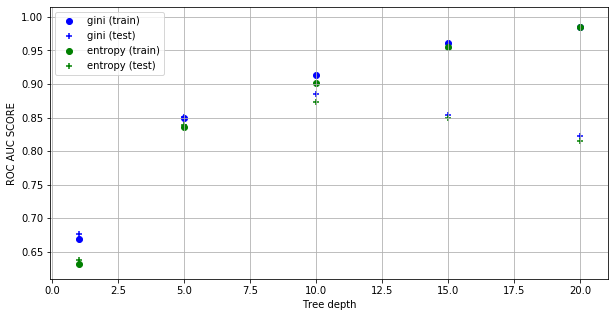

In [59]:
%%time
depths = [1,5,10,15,20]
criteria = ['gini','entropy']

train_auc = []
test_auc = []
for criterion in criteria:
    train_auc.append([])  # New criteria => new list
    test_auc.append([])
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth,criterion=criterion,class_weight="balanced")
        clf.fit(X_tr, y_tr)
        train_pred = clf.predict_proba(X_tr)
        y_pred = clf.predict_proba(X_val)
        train_auc[-1].append(roc_auc_score(y_tr,train_pred[:,1]))
        test_auc[-1].append( roc_auc_score(y_val,y_pred[:,1]))
        
plt.figure(figsize=(10, 5))
colors = "bgrc"
for ic, criterion in enumerate(criteria):
    plt.scatter(depths, train_auc[ic], color=colors[ic], 
             label=criterion+" (train)")
    plt.scatter(depths, test_auc[ic], color=colors[ic], marker = '+',
           label=criterion+" (test)")

    
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC SCORE")
plt.grid()
plt.legend(loc="best")


Gr√¢ce √† ce graphique nous constatons que le crit√®re de 'gini' donne de meilleurs r√©sultats. Par ailleurs, nous choisissons comme crit√®re d'arr√™t de l'algorithme la profondeur maximale de l'arbre. Une profondeur √©gale √† 10 semble √™tre un bon choix puisqu'en choisissant 15 ou 20 nous n'obtenons pas significativement de meilleurs r√©sultats sur la base de validation. De plus en choisissant une profondeur maximale trop importante nous risquons de cr√©er du sur apprentissage et l'algorithme sera plus long √† tourner.

In [69]:
%%time

TC= DecisionTreeClassifier(criterion='gini', max_depth=10,class_weight="balanced")
TC.fit(X_tr,y_tr)

Wall time: 30.6 s


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

R√©sultats sur la base d'entrainement

In [70]:
y_tr_pred = TC.predict_proba(X_tr)

In [71]:
roc_auc_score(y_tr, y_tr_pred[:,1])

0.9139954302860255

Afin de tracer la matrice de confusion nous utilisons un seuil = 0.5 pour fixer les predictions. Pour cela nous utilisons la m√©thode predict.

In [72]:
y_tr_pred_class=TC.predict(X_tr)

In [73]:
cm = confusion_matrix(y_tr, y_tr_pred_class)
cm

array([[392240,  63771],
       [  2900,  13521]], dtype=int64)

R√©sultats sur la base de validation 

In [78]:
y_val_pred = TC.predict_proba(X_val)

In [79]:
roc_auc_score(y_val, y_val_pred[:,1])

0.8849788823878135

In [76]:
y_val_pred_class=TC.predict(X_val)

In [77]:
cm = confusion_matrix(y_val, y_val_pred_class)
cm

array([[97899, 15967],
       [  940,  3302]], dtype=int64)

Ainsi, gr√¢ce √† cet algorithme nous obtenons des r√©sultats satisfaisants : sur la base d'entrainement nous obtenons une aire sous la courbe ROC √©gale √† environ 88.5 %. En visualisant la matrice de confusion nous constatons que nous ne classons pas l'ensemble de nos individus dans la classe des non fraudeurs, ce qui √©tait un risque li√© au d√©s√©quilibre dans nos donn√©es.

#### Soumission des r√©sultats sur Kaggle

In [90]:
preds_test = TC.predict_proba(Test)

temp1 = pd.DataFrame(Test['TransactionID'])
temp2 = pd.DataFrame({'isFraud': preds_test[:,1]})

submission_df = temp1.join(temp2)
submission_df.to_csv('datasets/kaggle_submission_TreeDecision.csv', index = False)

On obtient les r√©sultats suivants apr√®s soumission sur Kaggle : <code>ROC AUC = 0.8519</code>.

# III-  Random Forest

L'algorithme Random Forest est un algorithme de classification qui r√©duit la variance des pr√©visions d‚Äôun arbre de d√©cision seul. Pour cela, il combine de nombreux arbres de d√©cisions dans une approche de type bagging.

Le bagging (boostrap aggragating) consiste √† entrainer plusieurs classifieurs $(g_1, \dots, g_T)$, avec $g_t \colon \mathbb R^d \to \{0,1\}$ et de construire un nouveau classifieur en effectuant la moyenne des predictions des diff√©rents classifieurs
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right).
$$

Les classifieurs sont entrain√©s de fa√ßon quasiment ind√©pendante en effectuant du bootstrap sur la base d'entrainement.



Ainsi, comme pour l'algorithme de l'arbre de decision nous devons fixer une profondeur maximale de l'arbre et un crit√®re d'impuret√© (gini ou entropy) mais nous devons √©galement fixer le nombre de classifieurs √† entrainer parall√®lement.


In [44]:
from sklearn.ensemble import RandomForestClassifier

Wall time: 7min 44s


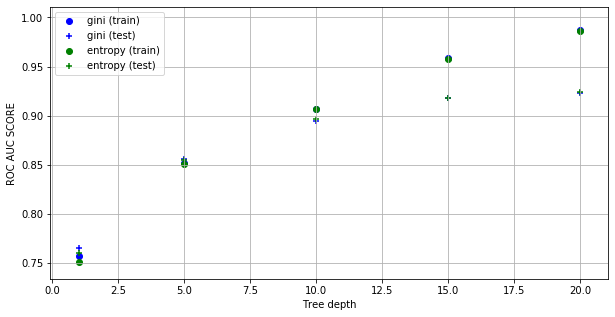

In [60]:
%%time
depths = [1,5,10,15,20]
criteria = ['gini','entropy']

train_auc = []
test_auc = []
for criterion in criteria:
    train_auc.append([])  
    test_auc.append([])
    for depth in depths:
        clf = RandomForestClassifier(n_estimators=50,  max_depth=depth,n_jobs=-1,criterion=criterion,class_weight="balanced")
        clf.fit(X_tr, y_tr)
        train_pred = clf.predict_proba(X_tr)
        y_pred = clf.predict_proba(X_val)
        train_auc[-1].append(roc_auc_score(y_tr,train_pred[:,1]))
        test_auc[-1].append( roc_auc_score(y_val,y_pred[:,1]))
        
plt.figure(figsize=(10, 5))
colors = "bgrc"
for ic, criterion in enumerate(criteria):
    plt.scatter(depths, train_auc[ic], color=colors[ic], 
             label=criterion+" (train)")
    plt.scatter(depths, test_auc[ic], color=colors[ic], marker = '+',
           label=criterion+" (test)")
    
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC SCORE")
plt.grid()
plt.legend(loc="best")

Ainsi, nous constatons que le crit√®re de gini est meilleur que celui de l'entropy, n√©anmoins la diff√©rence reste tr√®s faible. Par ailleurs, nous choisissons une profondeur d'arbre √©gale √† 10. En effet, les r√©sultats sur la base de validation n'augmentent pas significativement pour des profondeurs √©gales √† 15 ou 20. Si nous augmentons trop ce param√®tre, il y a un risque de sur apprentissage. Nous fixons donc cette valeur √† 10. 

Wall time: 2min 24s


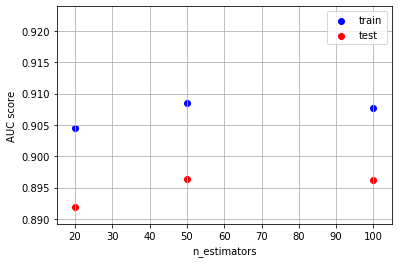

In [61]:
%%time



n_estimators = [20, 50, 100]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator,  max_depth=10,n_jobs=-1,criterion='gini',class_weight="balanced")
    rf.fit(X_tr, y_tr)
    train_pred = rf.predict_proba(X_tr)
    roc_auc = roc_auc_score(y_tr,train_pred[:,1])
    train_results.append(roc_auc)
    y_pred = rf.predict_proba(X_val)
    roc_auc =roc_auc_score(y_val,y_pred[:,1])
    test_results.append(roc_auc)
plt.scatter(n_estimators, train_results, color='blue',label="train" )
plt.scatter(n_estimators, test_results,  color='red',label="test")

plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.grid()
plt.legend(loc="best")



Nous choisissons de fixer le nombre d'estimateurs √† 50. En effet, en passant √† 100 classifieurs nous n'obtenons pas r√©ellement une diff√©rence significative au niveau des r√©sultats sur la base de validation.

In [80]:
%%time

rf= RandomForestClassifier(n_estimators=50,
                           criterion='gini', max_depth=10,
                           n_jobs=-1, class_weight="balanced")
rf.fit(X_tr,y_tr)


Wall time: 43.8 s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

R√©sultats sur la base d'entrainement

In [81]:
y_tr_pred = rf.predict_proba(X_tr)

In [82]:
roc_auc_score(y_tr, y_tr_pred[:,1])

0.9065713274340829

In [83]:
y_tr_pred_class=rf.predict(X_tr)

In [84]:
cm = confusion_matrix(y_tr, y_tr_pred_class)
cm

array([[403920,  52091],
       [  3799,  12622]], dtype=int64)

R√©sultats sur la base de validation 

In [85]:
y_val_pred = rf.predict_proba(X_val)

In [86]:
roc_auc_score(y_val, y_val_pred[:,1])

0.8956839579163057

In [87]:
y_tr_val_class=rf.predict(X_val)

In [88]:
cm = confusion_matrix(y_val, y_val_pred_class)
cm

array([[97899, 15967],
       [  940,  3302]], dtype=int64)

Ainsi, gr√¢ce √† cet algorithme nous obtenons des r√©sultats satisfaisants : sur la base d'entrainement nous obtenons une aire sous la courbe ROC √©gale √† environ 89.5 %. Nous obtenons donc comme esp√©r√© de meilleurs r√©sultats avec l'algorithme random forest qu'avec un seul arbre de d√©cision. N√©anmoins ces r√©sultats restent proches.

#### Soumission des r√©sultats sur Kaggle

In [89]:
preds_test = rf.predict_proba(Test)

temp1 = pd.DataFrame(Test['TransactionID'])
temp2 = pd.DataFrame({'isFraud': preds_test[:,1]})

submission_df = temp1.join(temp2)
submission_df.to_csv('datasets/kaggle_submission_RandomForest.csv', index = False)

On obtient les r√©sultats suivants apr√®s soumission sur Kaggle : <code>ROC AUC = 0.8929</code>.

<br><br>

# IV-  R√©seau de neurones

## IV- 1. G√©n√©ralit√©s

Les r√©seaux de neurones artificiels font partie de la famille des algorithmes d'apprentissage supervis√© qui consiste √† apprendre une fonction de pr√©diction √† partir d'une base de donn√©es labellis√©es. Plus formellement, l'apprentissage supervis√© consiste √† estimer une fonction $f$ √† partir d'une base d'apprentissage $((x_i,f(x_i))_{i\in [1,n]}$ et $\forall{i},x_i \in \mathbb{R}^p,p\geq 1$.  
Le principe d'estimation est de trouver une fonction g,  une approximation de f qui minimise l'erreur moyenne $\frac{1}{n}\sum_{i=1}^{n} L(g(x_i),f(x_i))$ o√π L est une fonction de co√ªt.  

## IV- 2. Le neurone

Ci-dessous la repr√©sentation d'un r√©seau de neurones √† 6 couches:  

<img src="images/reseaux.PNG" width="500"> 

Les couches vertes, bleues et rouges sont appel√©es respectivement les couches d'entr√©e, cach√©es et de sortie  du r√©seau. Quand il ya un tr√®s grand nombre de couches cach√©es, on parle alors de r√©seauprofond.  

Un neurone est une unit√© √©l√©mentaire du r√©seau qui, sous la stimulation des neurones des couches pr√©c√©dentes, produit un signal de r√©ponse transmis aux neurones des couches suivantes. Ce signal vaut typiquement $1$ si la stimulation du neurone est sup√©rieure √† un certain seuil d'activation, $0$ sinon. Les poids de connexion du neurone et ce seuil forment ainsi la m√©moire ou la connaissance du neurone.

Un neurone est mod√©lis√© de mani√®re simple comme une unit√© de r√©gression logistique d√©finie comme la composition d'une fonction d'agr√©gation par une fonction d'activation. Le r√¥le de la fonction d'agr√©gation est de combiner les signaux d'entr√©es et les poids du neurone en une valeur scalaire, c'est-√†-dire de former la stimulation du neurone. La fonction d'activation vise √† produire la valeur de r√©ponse du neurone en fonction de la valeur de combinaison, c'est-√†-dire de comparer la stimulation au seuil d'activation. L'ensemble des poids de connexion et le seuil auront des valeurs d√©termin√©es durant la phase d'apprentissage. Ces param√®tres caract√©risent une partie de la connaissance acquise ou apprise par le neurone.

Consid√©rons le neurone $j$ de la couche $\ell$ du r√©seau. La r√©ponse produite par ce neurone est not√© $a^{[\ell]}_{j}$. On note $\omega^{[\ell]}_{j,k}$ le poids de connexion entre le neurone $j$ de la couche $\ell$ et le neurone $k$ de la couche $\ell-1$. Enfin, on note $b^{[\ell]}_{j}$ le biais associ√© au neurone. La fonction de combinaison est une fonction lin√©aire de pond√©ration des signaux d'entr√©e par les poids de connexion :
$$
z^{[\ell]}_{j} = \sum_{k} \omega^{[\ell]}_{j,k} \: a^{[\ell-1]}_{k} + b^{[\ell]}_{j}.
$$
Notons que l'on a $a^{[0]} = x$ et $\tilde{y} = a^{[L]}$ o√π $L$ est la derni√®re couche du r√©seau. L'application de fonction d'activation not√©e $\sigma(z)$ produit la r√©ponse du neurone :
$$
a^{[\ell]}_{j} = \sigma(z^{[\ell]}_{j}).
$$
Dans la litt√©rature, la fonction $\sigma(z)$ est appel√©e fonction d'activation et peut avoir plusieurs formes ayant un impact sur la rapidit√© d'apprentissage.  

## IV- 3. Principe d'apprentissage du r√©seau

L'apprentissage par le r√©seau s'effectue en deux √©tapes: le forward propagation (propagation avance ) et le back propagation (propagation arri√®re ou r√©tro-propagation)  
- **Le Forward propagation:**  
Le forward propagation consiste √† effectuer des op√©rations matricielles  entre la donn√©e d'entr√©e, les poids synaptiques, les biais et √† appliquer les diff√©rentes fonctions d'activation.  
- **Le back propagation:**  
L'algorithme du back propagation est une m√©thode qui permet de former efficacement le r√©seau de neurones.
Apr√®s une initialisation des param√®tres du r√©seau (poids et biais), l'√©tape de la propagation avant permet d'obtenir une valeur pr√©dicte. La r√©tro-propagation consiste √† travers des algorithmes d'optimisation( algorithme de descente du gradient exploitant la r√®gle de la cha√Æne ) √† trouver les param√®tres optimaux qui minimisent la fonction de co√ªt( fonction de mesure de l'√©cart entre la vraie valeur et celle pr√©dicte par le reseau).En un mot, la r√©tropropagation est une m√©thode it√©rative , r√©cursive et efficace pour calculer les mises √† jour des poids et biais afin d‚Äôam√©liorer le r√©seau jusqu‚Äô√† ce qu‚Äôil soit capable d‚Äôex√©cuter la t√¢che pour laquelle il est form√©. Math√©matiquement cela consiste √† r√©soudre le probl√®me d'optimisation:
\begin{equation}
argmin_{\omega ,b} \frac{1}{m} \sum_{i} L({\hat{y}^{(i)}}, y^{(i)})
\end{equation}  
Dans notre situation (classification binaire), la fonction L est la fonction d'entropie crois√©e d√©finie par:  
$\ell(\hat{y}_j,y_j)=-y_jlog(\hat{y_j})-(1-y_j)log(1-\hat{y_j})$.  

## IV- 4. Mise en place du mod√®le avec le module keras


Avant la mise en place du mod√®le keras, nous avons d√©cider d'appliquer l'ACP sur les donn√©es afin de r√©duire la dimension des donn√©es et donc r√©duire le nombre de param√®tres du r√©seau

Text(0, 0.5, 'Cumulative explained variance')

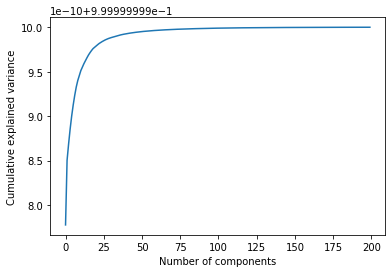

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
pca.fit(X_rs)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Comme l'indique le graphique, 95% de l'information contenue dans les donn√©es est r√©present√©e par 12 composantes principales. Ainsi nous construirons notre mod√®le de r√©seaux de neurones avec une dimension de donn√©es √©gal √† 12

In [38]:
NCOMPONENTS = 12

pca = PCA(n_components=NCOMPONENTS)
X_pca_ran = pca.fit_transform(X_ran)
X_pca_val = pca.transform(X_val)
print(X_ran.shape)
print(X_pca_ran.shape)
print(X_pca_val.shape)

(912022, 219)
(912022, 12)
(118108, 12)


In [40]:
#Importation des biblioth√®ques utiles
import keras
import random
from keras.models import Model,Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation,GaussianNoise
from keras.optimizers import Adam, Nadam
from keras.callbacks import EarlyStopping
from keras.initializers import he_normal
from keras.utils import plot_model
import tensorflow as tf
import pydot

On d√©v√©loppe un callback pour la visualisation du score de ROC_AUC pendant l'entraitement:

In [41]:
from keras.callbacks import Callback
class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict(self.x)
        roc_train = roc_auc_score(self.y, y_pred_train)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

Cr√©ation du r√©seau de neurones

In [42]:
def create_model():
    inps = Input(shape=(NCOMPONENTS,))
    x = Dense(1082, activation="relu",kernel_initializer="uniform")(inps)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation="relu",kernel_initializer="uniform")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation="relu",kernel_initializer="uniform")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(102, activation="relu",kernel_initializer="uniform")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x= Dense(200,activation="relu",kernel_initializer="uniform")(x)
    x = Dense(1, activation='sigmoid',kernel_initializer="uniform")(x)
    model = Model(inputs=inps, outputs=x)
    optimizer = Adam(lr=0.0005)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    model.summary()
    return model

In [43]:
classifier=create_model()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1082)              14066     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1082)              4328      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1082)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               554496    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_______________________________

In [44]:
%%time
roc = RocCallback(training_data=(X_pca_ran, y_ran),
                  validation_data=(X_pca_val, y_val))

earlystopping=EarlyStopping(monitor='val_loss', patience=2, verbose=0, 
                            mode='auto', baseline=None, restore_best_weights=True)
classifier.fit(
    X_pca_ran, y_ran, epochs=8, batch_size=256, validation_data=(X_pca_val, y_val), verbose=True, 
    callbacks=[earlystopping,roc]
)


Train on 912022 samples, validate on 118108 samples
Epoch 1/8
912022/912022 [==============================] - 791s 867us/step - loss: 0.6891 - accuracy: 0.5356 - val_loss: 0.6640 - val_accuracy: 0.4246
roc-auc_train: 0.5563 - roc-auc_val: 0.5551                                                                                                    
Epoch 2/8
912022/912022 [==============================] - 653s 716us/step - loss: 0.6885 - accuracy: 0.5368 - val_loss: 0.6817 - val_accuracy: 0.5126
roc-auc_train: 0.5545 - roc-auc_val: 0.5513                                                                                                    
Epoch 3/8
912022/912022 [==============================] - 570s 625us/step - loss: 0.6884 - accuracy: 0.5373 - val_loss: 0.6825 - val_accuracy: 0.3414
roc-auc_train: 0.5563 - roc-auc_val: 0.5551                                                                                                    
Epoch 4/8
912022/912022 [==============================] - 569

In [45]:
y_val_pred = classifier.predict(X_pca_val)
print('ROC AUC = {}'.format(np.round(roc_auc_score(y_val,y_val_pred),3)))

#Converting into binary values
y_val_pred=y_val_pred>=0.5
cm_nn = confusion_matrix(y_val, y_val_pred)
print("\nMatrice de confusion :\n{}".format(cm_nn))

ROC AUC = 0.555

Matrice de confusion :
[[47386 66480]
 [ 1478  2764]]


Nous avons un score faible avec ce mod√®le compar√© aux autres algorithmes de classification utilis√©s. Celui-ci est l√©g√®rement meilleur qu'un lancer de pi√®ce.

<br><br>

# V-  Gradient Boosting

## V- 1. Pr√©sentation de la m√©thode

<b><u>Boosting</u></b> : Le boosting est une variante du bagging [Breiman, 1996]. Pour le bagging, on cr√©e $B$ sous-√©chantillons en tirant uniform√©ment (avec remise) dans le jeu de donn√©es, puis on fabrique $B$ estimateurs. Notre estimateur final est une aggr√©gation de ces $B$ estimateurs (ce qui permet d'obtenir un estimateur avec une variance r√©duite). En r√©gression, nous prenons simplement la moyenne des $B$ estimateurs. En classification, on proc√®de par vote majoritaire.<br>    
    
Lors de la proc√©dure de boosting [<a href="http://rob.schapire.net/papers/strengthofweak.pdf">Schapire, 1990</a>], on cr√©e un premier √©chantillon en tirant uniform√©ment dans le jeu. Puis, on cr√©e un deuxi√®me sous-√©chantillon en tirant d'abord les observations qui ont fait chuter le score global dans le sous-√©chantillon pr√©c√©dent, et on compl√®te avec des observations tir√©es uniform√©ment (avec remise √©galement). On peut par exemple prendre une moiti√© correspondant √† des observations mal class√©es par le premier estimateur, et une moiti√© al√©atoire. Puis un troisi√®me √©chantillon en prenant d'abord des observations pour lesquelles les deux premiers estimateurs sont en d√©saccord. Et ainsi de suite jusqu'√† obtenir nos $B$ estimateurs. On effectue ensuite une aggr√©gation de ces estimateurs de la m√™me mani√®re que pour le <b>bagging</b>. Le boosting est donc strictement meilleur que le bagging.

<u>Remarque</u> : En pratique, nous prenons $B\approx 500$ sous-√©chantillons.

Plus concr√®tement, notons $h_b$ $(b=1, ..., B)$ les estimateurs que nous obtenons sur chacun de nos sous-√©chantillons et $\mathcal{H}$ l'ensemble sur lequel on tire ces estimateurs. Ceux-ci sont g√©n√©ralement des <b>estimateurs faibles</b> (<i>weak learners</i>). Un estimateur $h:\mathbb{R}^D \to \mathcal{Y}$ est dit faible si :
<ul>
    <li>En r√©gression : $h$ est au moins meilleur qu'une moyenne sur les $y_i$</li>
    <li>En classification : $h$ est au moins meilleur qu'un lancer de pi√®ce</li>
</ul>  
Ensuite, nous combinons ces $B$ estimateurs faibles (principe g√©n√©ral de l'<b>apprentissage ensembliste</b>) de la mani√®re suivante :
$$g_B(x) = \sum_{b=1}^B \eta_b h_b(x)$$
avec $\eta_b \in \mathbb{R}$. Le but √©tant de trouver $h_1, ..., h_b, \eta_1, ..., \eta_B$ qui minimisent le score global $\frac{1}{n} \sum_{i=1}^n l(y_i,g_B(x_i))$. Cette m√©thode est donc tr√®s g√©n√©rale puisque les proc√©dures qui cr√©ent les estimateurs $(h_b)_{b=1,...,B}$ peuvent √™tre extr√™ment diff√©rentes. Par ailleurs, le r√©sultat de l'algorithme d√©pend aussi du choix de la perte $l$.

L'id√©e basique serait de trouver √† chaque √©tape $b$ du boosting le meilleur estimateur en effectuant une <b>minimisation exacte</b>. On initialise un $\hat h_1$ et un $\hat \eta_1$. Puis, on cr√©e une suite $\hat g_1, ..., \hat g_B$ d'estimateurs id√©aux ($\hat g_1 = \hat h_1$) : $b=1,...,B-1$
$$(\hat h_{b+1}, \hat \eta_{b+1}) = \text{argmin}_{h \in \mathcal{H}, \eta \in \mathbb{R}} \sum_{i=1}^n l(y_i, \hat g_b(x_i) + \eta h(x_i) )$$
et on fixe $$\hat g_{b+1} = \hat g_b + \hat \eta_{b+1} \hat h_{b+1}$$
On obtient l'estimateur $\hat g(x) = \hat g_B(x) = \sum_{b=1}^B \eta_b h_b(x)$. Cependant, comme on peut s'y attendre, cette proc√©dure de minimisation exacte est en pratique trop compliqu√©e √† mettre en place. On introduit alors le concept de gradient boosting.

<b><u>Gradient Boosting</u></b> : Le principe est de remplacer chaque √©tape de minimisation exacte par une √©tape de descente de gradient. On remplace $\text{argmin}_{h \in \mathcal{H} } \sum_{i=1}^n l(y_i, \hat g_b(x_i) + \eta h(x_i) )$ par 
$$\text{argmin}_{u \in \mathbb{R} } \sum_{i=1}^n l(y_i, \hat g_b(x_i) + \eta u )$$
Etape 1 : On effectue un pas dans la direction suivante 
$$\hat \delta_b = \nabla_u \left( \sum_{i=1}^n l(y_i, \hat g_b(x_i) +u) \right)_{| u=0}$$

Etape 2 : Ensuite, il s'agit de prendre un $\hat h \in \mathcal{H}$ proche de ce $\hat \delta_b$. On prends le minimiseur suivant :
$$(\hat h, \hat \nu) = \text{argmin}_{h \in \mathcal{H}, \nu \in \mathbb{R}} \sum_{i=1}^n (\nu h(x_i)) - \hat \delta_b(i))^2 $$

Ainsi, pour la perte des moindres carr√©s par exemple, nous aurions 
$$\hat \delta_b^{MC} = (\hat g_b(x_1) - y_1, ... , \hat g_b(x_n) - y_n )^T$$
et donc 
$$(\hat h, \hat \nu) = \text{argmin}_{h \in \mathcal{H}, \nu \in \mathbb{R}} \sum_{i=1}^n (\nu h(x_i)) - \hat g_b(x_i) + y_i)^2$$
Nous cherchons donc un estimateur faible $\hat h_{b+1}$ qui corrige l'erreur r√©siduelle √† l'√©tape $b$ : $y_i - \hat g_b(x_i)$. On d√©termine ensuite le $\hat \eta_{b+1}$ :
$$\hat \eta_{b+1} = \text{argmin}_{\eta \in \mathbb{R}} \sum_{i=1}^n l(y_i, \hat g_b(x_i) + \eta \hat h_{b+1}(x_i) )$$
On obtient √† la fin de l'algorithme l'estimateur $\hat g_B$.

<u>Initialisation du gradient boosting</u> : on peut prendre par exemple l'estimateur suivant $\hat g_0 = \text{argmin}_{m \in \mathbb{R}} \sum_{i=1}^n l(y_i,m)$ 

<u>Remarque</u> : Il existe de nombreuses impl√©mentations de Gradient Boosting dans la litt√©rature. On peut notamment citer : AdaBoost, XGBoost, pGBRT, scikit-learn, gbm (R).

<u>Exemple</u> : AdaBoost (pour Adaptative Boosting) est une m√©thode connue de Gradient Boosting qui consiste √† choisir la perte $l(x,y) = \exp (xy)$. Ainsi, au fur et √† mesure des √©tapes de boosting, on se focalise sur les observations qui sont mal estim√©es (facteur exponentiel). On utilise souvent cette m√©thode en prenant comme estimateurs faibles des arbres de d√©cisions (ou CART).

<br>


## V- 2. XGBoost


<a href="https://xgboost.readthedocs.io/en/latest/">XGBoost</a> (pour eXtreme Gradient Boosting) est un algorithme bas√© sur la m√©thode du Gradient Boosting qui est optimis√© pour fournir de bons r√©sultats sur des probl√®mes tr√®s vari√©s. Celui-ci utilise comme estimateurs faibles des arbres de d√©cisions et ajoute une r√©gularisation $\Omega (h_b)$ pour limiter le sur-apprentissage. Parmi les impl√©mentations de Gradient Boosting cit√©es plus haut, XGBoost est la meilleure (cf "<a href="https://arxiv.org/pdf/1603.02754.pdf">XGBoost: A Scalable Tree Boosting System</a>").

Ainsi, nous avons (avec les m√™mes notations que dans la section pr√©c√©dente :
<ul>
    <li>$\mathcal{H} = $ CART (Classification And Regression Trees)</li>
    <li>$\hat h_{b+1} = \text{argmin}_{h \in \mathcal{H}} \sum_{i=1}^n l(y_i, \hat g_b(x_i) + h(x_i) ) + \Omega(h)$ avec $\Omega(h) = \gamma T + \frac{1}{2} \lambda||w||^2$ o√π $T$ est le nombre de feuilles de l'arbre, $w$ les poids, $(\gamma, \lambda)$ les param√®tres de r√©gularisation. Ainsi, le premier terme $\gamma T$ p√©nalise les mod√®les complexes et le deuxi√®me terme $\frac{1}{2} \lambda||w||^2$ permet d'√©viter le sur-apprentissage.</li> 
</ul>   

NB : Il est aussi possible de prendre $\mathcal{H} = $ fonctions lin√©aires. 

<br><br>

In [46]:
import xgboost as xgb

<u>Donn√©es non √©quilibr√©es</u> : Nous disposons de donn√©es non √©quilibr√©e (beaucoup plus de non fraudeurs que de fraudeurs). XGBoost peut g√©rer cela √† l'aide du param√®tre <code>scale_pos_weight</code>. Dans notre classification binaire, on peut donner √† ce param√®tre par exemple le ratio d'instances n√©gatives (non fraudeur) sur les instances positives (fraudeur) : 

$$\frac{\sum \text{neg instances}}{\sum \text{pos instances}} $$

In [47]:
y_train = Train[target]
x = np.array(y_train)
print("Nb de fraudeurs = ",(x==1).sum())
print("Nb de non fraudeurs = ", (x==0).sum())
print("ratio = ", (x==0).sum()/(x==1).sum())

Nb de fraudeurs =  20663
Nb de non fraudeurs =  569877
ratio =  27.579586700866283


On fixe donc notre param√®tre <code>scale_pos_weight</code> :
$$\frac{\sum \text{not fraud}}{\sum \text{fraud}} \approx 28$$
Par ailleurs, nous utiliserons dans un premier temps les <a href="https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst">param√®tres</a> suivants :
<ul>
    <li>les estimateurs faibles $(h_b)_{1 \leq b \leq B}$ CART : <code>booster='gbtree'</code>
    <li>la profondeur des arbres de classification (profondeur $P$, nombre de feuilles $T$ : $T = 2^P$): <code>max_depth = 3</code></li>
    <li>le pas : <code>learning_rate = 0.1</code></li>
    <li>le nombre d'arbres par d√©faut : <code>n_estimators = 100</code></li>
    <li>le terme de r√©gularisation $\lambda$ par d√©faut : <code>reg_lambda = 1</code> (correspond au $\lambda$ dans la p√©nalisation $\Omega(h) = \gamma T + \frac{1}{2} \lambda||w||^2$)</li>
    <li>la fonction objectif : <code>objective='binary:logistic'</code> qui renvoie des probabilit√©s</li>
    <li>la m√©trique d'√©valuation : <code>eval_metric = error</code> (calcul√© par la formule : #(wrong cases)/#(all cases))
</ul>    


In [48]:
xg_clf = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, reg_lambda=1, scale_pos_weight=28, objective='binary:logistic')

In [49]:
%%time
xg_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=0)

CPU times: user 11min 40s, sys: 11.1 s, total: 11min 51s
Wall time: 11min 55s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=28, seed=None,
              silent=None, subsample=1, verbosity=1)

<br>

<u>Performances</u> : Pour √©valuer notre algorithme XGBoost on peut comme pour les autres m√©thodes regarder la matrice de confusion ainsi que l'AUC (<i>Area Under the Curve</i>) de la courbe ROC. On remarque par ailleurs que le processus d'apprentissage de l'algorithme √† nos donn√©es a dur√© <b>13 minutes</b>. Cela est assez long, notamment si l'on veut modifier certains param√®tres.

<br>

In [50]:
preds_xgb = xg_clf.predict(X_val)
print('ROC AUC = {}'.format(np.round(roc_auc_score(y_val,preds_xgb),3)))
cm_xgb = confusion_matrix(y_val, preds_xgb)
print("\nMatrice de confusion :\n{}".format(cm_xgb))

ROC AUC = 0.81

Matrice de confusion :
[[96087 17779]
 [  952  3290]]


<u>Observation</u> : On obtient un ROC AUC de 81.0%, ce qui est un score plut√¥t bon au vu des autres m√©thodes jusqu'ici utilis√©.

#### Soumission des r√©sultats sur Kaggle

In [51]:
preds_test_xgb = xg_clf.predict(Test)

temp1 = pd.DataFrame(Test['TransactionID'])
temp2 = pd.DataFrame({'isFraud': preds_test_xgb})

submission_df = temp1.join(temp2)
submission_df.to_csv('datasets/kaggle_submission_xgb.csv', index = False)

On obtient les r√©sultats suivants apr√®s soumission sur Kaggle : <code>ROC AUC = 0.826326</code>.

<br><br>
## V- 3. Light GBM

LightGBM (pour Light Gradient Boosting Machine) [<a href="https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf">Microsoft Research, 2017</a>] est une variante de Gradient Boosting qui incorpore deux nouvelles m√©thodes :
<ul>
    <li>Gradient-based One-Side Sampling</li>
    <li>Exclusive Feature Bundling</li>
</ul>
qui permettent de meilleurs r√©sultats lorsque le nombre d'observations est √©lev√© pour le premier et lorsque le nombre de features est √©lev√© pour le deuxi√®me. Ici nous sommes dans les deux cas. Cet algorithme peut √™tre, selon le contexte, meilleur que XGBoost. A noter que les chercheurs de Microsoft ont d√©velopp√© LightGBM apr√®s l'apparition de XGBoost (2014).

In [22]:
import lightgbm as lgb

<br>

Comme pour XGBoost, il existe un param√®tre <code>scale_pos_weight</code> qui permet de g√©rer les jeu de donn√©es non √©quilibr√©s. On fixe donc comme pr√©c√©demment <code>scale_pos_weight = 28</code>.

NB : il existe un param√®tre <code>is_unbalanced</code> qui fait la m√™me chose mais celui-ci calcule automatiquement le ratio. Pour avoir quelque chose proche des param√®tres de XGBoost on privil√©giera <code>scale_pos_weight</code>. 

Par ailleurs, nous utiliserons dans un premier temps les <a href="https://lightgbm.readthedocs.io/en/latest/Parameters.html">param√®tres</a> suivants :
<ul>
    <li>les arbres de classification comme estimateurs faibles $(h_b)_{1 \leq b \leq B}$ : <code>boosting='gbdt'</code> (Gradient Boosting Decision Tree)
    <li>la profondeur des arbres de classification : <code>max_depth = 3</code></li>
    <li>le pas : <code>learning_rate = 0.1</code></li>
    <li>le nombre d'arbres par d√©faut : <code>n_estimators = 100</code></li>
    <li>le terme de r√©gularisation $\lambda$ par d√©faut : <code>reg_lambda = 1</code></li>
    <li>la fonction objectif : <code>objective='binary:logistic'</code> qui renvoie des probabilit√©s</li>
</ul>    

<br>

In [23]:
lgb_clf = lgb.LGBMClassifier(scale_pos_weight=28)

In [24]:
%%time
d_train = lgb.Dataset(X_tr, label=y_tr)
params = {}
params['objective'] = 'binary'
params['scale_pos_weight'] = 28
clf = lgb.train(params, d_train, 100)  #100 = nb of iterations

CPU times: user 1min 52s, sys: 3.44 s, total: 1min 55s
Wall time: 38.9 s


In [25]:
#Prediction
preds = clf.predict(X_val)
print('ROC AUC = {}'.format(np.round(roc_auc_score(y_val,preds),3)))

#Convert into binary values for confusion matrix
for i in range(len(X_val)):
    if preds[i]>=.5:       
        preds[i]=1
    else:  
        preds[i]=0
        
cm = confusion_matrix(y_val, preds)
print("\nMatrice de confusion :\n{}".format(cm))

ROC AUC = 0.931

Matrice de confusion :
[[100986  12880]
 [   761   3481]]


<u>Observation</u> : On obtient un ROC AUC de <b>93.1%</b> ce qui est sup√©rieur √† celui obtenu par XGBoost. Par ailleurs, le temps d'apprentissage de l'algorithme est largement inf√©rieur √† celui de XGBoost : <b>30 secondes contre 13 minutes</b>.
<br><br>
On peut aussi regarder les r√©sultats de pr√©dictions avec le <i>train set</i> pour v√©rifier que l'on a un score assez proche de celui du <i>validation set</i>.

In [32]:
#Prediction
preds_tr = clf.predict(X_tr)

print('ROC AUC train set = {}'.format(np.round(roc_auc_score(y_tr,preds_tr),3)))

ROC AUC train set = 0.943


Et la matrice de confusion du <i>train set</i> est :

In [33]:
#convert into binary values
for i in range(len(X_tr)):
    if preds_tr[i]>=.5:       
        preds_tr[i]=1
    else:  
        preds_tr[i]=0
cm_tr = confusion_matrix(y_tr, preds_tr)
print("Matrice de confusion train set :\n{}".format(cm_tr))

Matrice de confusion train set :
[[404248  51763]
 [  2563  13858]]


<u>Remarque</u> : Le ROC AUC pour le <i>train set</i> est l√©g√®rement sup√©rieur (sup√©rieur de 3 points). Ceci est normal et ne signifie pas n√©cessairement que l'on est en situation de sur-apprentissage.

#### Soumission des r√©sultats sur Kaggle

In [70]:
preds_test = clf.predict(Test)

temp1 = pd.DataFrame(Test['TransactionID'])
temp2 = pd.DataFrame({'isFraud': preds_test})

submission_df = temp1.join(temp2)
submission_df.to_csv('datasets/kaggle_submission_lgbm.csv', index = False)

On obtient les r√©sultats suivants apr√®s soumission sur Kaggle : <code>ROC AUC = 0.921088</code> (1940e place sur 6400).

## V- 4. Conclusion 

Les performances du gradient boosting sont tr√®s bonnes, m√™me avec les param√®tres par d√©faut. Par ailleurs, on peut voir que le logiciel de Microsoft Research  est extr√™mement rapide, ce qui est un net avantage sur XGBoost. Nous avons utilis√© deux m√©thodes qui sont sans doute les plus employ√©es actuellement parmi les m√©thodes de Gradient Boosting. Par ailleurs, une autre m√©thode tr√®s puissante que nous aurions pu utiliser est [CatBoost](https://catboost.ai/) dont le code est pass√© en open-source en avril 2017, juste apr√®s l'apparition de LightGBM (janvier 2017). Ce logiciel de Gradient Boosting a √©t√© d√©velopp√© par la soci√©t√© russe Yandex et rivalise souvent avec LightGBM et XGBoost.

<br><br>

# VI- Support Vector Machine (SVM)

Support Vector Machine (SVM) est un algorithme d'apprentissage machine supervis√© capable d'effectuer une classification (lin√©aire et non lin√©aire), une r√©gression et m√™me une d√©tection des valeurs aberrantes propos√© par Valdimir Vapnik en 1963.

## VI- 1. Fonctionnement de SVM
#### 1) Cas lin√©airement s√©parable

Le classificateur SVM lin√©aire fonctionne en tra√ßant une ligne droite entre deux classes. Tous les points de donn√©es qui tombent du cot√© droit de la ligne seront √©tiquet√©s comme une classe {+} et tous les points qui tombent de l'autre c√¥t√© seront √©tiquet√©s comme classe {-}. 

Cela semble assez simple, mais il y a une quantit√© infinie de lignes(hyperplan) parmi lesquelles vous pouvez choisir. Comment savoir quelle ligne permettra de classer au mieux les donn√©es ? C'est l√† que l'algorithme SVM Lin√©aire entre en jeu. 

L'algorithme SVM Lin√©aire va s√©lectionner une ligne qui non seulement s√©pare les deux classes mais qui reste aussi loin que possible des √©chantillons les plus proches. En fait, le " vecteur support " dans " machine √† vecteur support " d√©signe deux vecteurs de position tir√©s de l'origine aux points qui dictent la limite de d√©cision.

<img src="images/image1.png" width="500"> 

##### Formulation du SVM

Consid√©rons nos donn√©es : $n$ points en $p$ dimensions, repr√©sent√©s par la matrice  $ X \in \mathbb{R}^{n \times p}$, d'√©tiquettes repr√©sent√©es par un vecteur $ y \in \{-1,1\}^n $.\\

L'√©quation d'un hyperplan en dimension $p$ est param√©tr√©e par les coordonn√©es du vecteur normal √† cet hyperplan, $ \textbf{w}\in \mathbb{R}^p$ ainsi que par un scalaire $ b \in \mathbb{R}$ . Nous pouvons ainsi poser que l'√©quation de notre hyperplan s√©parateur de marge maximale $ \mathcal{H} $ est $ \langle \textbf{w},b \rangle + b =0$ .

Les hyperplans  $ \mathcal{H}_+ $ et  $ \mathcal{H} _-$ sont parall√®les √†  $ \mathcal{H} $ et ont donc le m√™me vecteur normal $ \textbf{w}$  . De plus, ils sont √©quidistants par rapport √†  $ \mathcal{H} $ , et leurs √©quations peuvent donc s'√©crire  $ \mathcal{H}_+ $:$ \langle \textbf{w},b \rangle + b =K$ et  $ \mathcal{H}_- $:$ \langle \textbf{w},b \rangle + b =-K$ ou K est une constante. Comme nous pouvons arbitrairement multiplier $ \textbf{w}$ , b et K par n'importe quel scalaire pour obtenir les m√™mes √©quations, nous pouvons fixer K=1 , et ainsi avoir   $ \mathcal{H}_+ $:$ \langle \textbf{w},b \rangle + b =1$ et  $ \mathcal{H}_- $:$ \langle \textbf{w},b \rangle + b =-1$.

<img src="images/9.jpg" width="500"> 

En utilisant ces √©quations pour calculer la marge $ \gamma $ on obtient: $ \gamma = \dfrac{2}{\parallel \textbf{w} \parallel_2} $

l'objectif consite √† r√©soudre ce probl√®me d'optimisation:
	$$ \text{argmax}_{\textbf{w}\in\mathbb{R}^p,b\in \mathbb{R} } \dfrac{2}{\parallel \textbf{w} \parallel_2} \quad\text{avec} \quad  y_i \left( \langle \textbf{w},x_i \rangle + b\right)  \geq 1 \qquad i \in\{1,....,n\}$$
    
   Pour simplifier les calculs le prob√®me devient:
   \begin{equation}
\left\lbrace
\begin{array}{l l }
\text{min} \quad  \dfrac{1}{2} \parallel \textbf{w} \parallel_2^2  &  \textbf{w}\in\mathbb{R}^p,b\in \mathbb{R}\\
\text{s.c}  \quad  y_i \left( \langle \textbf{w},x_i \rangle + b\right)  \geq 1 & \quad \forall i \in\{1,....,n\}
\end{array}
\right.
\end{equation}



avec pour fonction de d√©cision: $ f(x)=\langle \textbf{w}^*,x \rangle + b^*$


Le probl√®me d√©fini par l'√©quation pr√©c√©dente est un probl√®me d'optimisation convexe sous $ n $ contraintes affines. Par une technique connue sous le nom des multiplicateurs de Lagrange, ce probl√®me primal peut √™tre reformul√© par 
\begin{equation}
\left\lbrace
\begin{array}{l l }
\max_{\alpha\in \mathbb{R}^n} \quad  - \dfrac{1}{2} \sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j\alpha_i \alpha_j \langle x_i,x_j \rangle + \sum_{i=1}^{n}\alpha_i &  \\
\text{s.c}  \quad \alpha_i \geq 0, \quad \forall i \in\{1,....,n\} \quad \text{et} \quad \sum_{i=1}^{n}\alpha_i y_i =0 
\end{array}
\right.
\end{equation}
les coefficients $ \alpha_i$ v√©rifient les conditions de Karush-Kuhn-Tucker.


* soit  $  \alpha_i=0$
et  $ y_i \left( \langle \textbf{w},x_i \rangle + b\right)  - 1  \geq 0 $,
 alors:  $ y_i \left( \langle \textbf{w},x_i \rangle + b\right)   > 1 $. En d'autres termes,  $ x_i$ est situ√© √† l'ext√©rieur de la fronti√®re de la zone d'ind√©cision. Cela voudrait que le nombres de contraintes effectifs qu'on aura dans le probl√®me d'optimisation d√©pendra  simplement du nombre de points $ x_i $ qui seront sur $ \mathcal{H}_+$ et $ \mathcal{H}_-$, dans ce cas le nombre de variables ne sera plus $ n $ mais le nombre de points sur $ \mathcal{H}_+$ et $ \mathcal{H}_-$. 


* soit   $  \alpha_i>0$
et$ y_i \left( \langle \textbf{w},x_i \rangle + b\right)  - 1  = 0 $ alors : $ y_i \left( \langle \textbf{w},x_i \rangle + b\right)   = 1 $. En d'autres termes,  $ x_i $
est situ√© sur la fronti√®re de la  zone d'ind√©cision.
Cela signifie que les points $ x_i$
pour lesquels  $  \alpha_i>0$ sont les vecteurs de support, et ceux pour lesquels  $  \alpha_i=0$ sont ceux situ√©s loin de $ \mathcal{H}_+$ et $ \mathcal{H}_-$ .


Ainsi le vecteur poids $ \textbf{w}^* =  \sum_{i=1}^{n} \alpha_i y_i x_i \alpha^*$ et
$  b^* = - \dfrac{\max_{y_i=-1}\langle \textbf{w}^*,x_i \rangle + \min_{y_i=-1}\langle \textbf{w}^*,x_i \rangle}{2} $	

## Remarque 

Autrement dit que certains points de notre jeu d'entra√Ænement se retrouvent du mauvais c√¥t√© de la fronti√®re de la zone d'ind√©cision, et que l'hyperplan ne soit pas la meilleur solution au probl√®me de classement

<img src="images/23.JPG" width="500"> 


En 1995, Vladimir Vapnik et Corinna Cortes ont propos√© ue technique dite   Soft SVM qui tol√®re les mauvais classements. Cette technique cherche un hyperplan s√©parateur qui minimise le nombre d'erreurs gr√¢ce √† l'introduction de variables relaxes $ \xi_i$ (slack variable)  qui permettent le d√©placement des points mal class√©s

Le probl√®me d'optimisation est √©quivalent √†:
  \begin{equation}
\left\lbrace
\begin{array}{l l l}
\text{min} \quad  \dfrac{1}{2} \parallel \textbf{w} \parallel_2^2 + C \sum_{i=1}^{n} \xi_i, &  \textbf{w}\in\mathbb{R}^p,b\in \mathbb{R} \\
\text{s.c}  \quad   y_i \left( \langle \textbf{w},x_i \rangle + b\right)   \geq 1-\xi_{i} & \quad \forall i \in\{1,...,n\} \\ 
\text{et} \quad \xi_i \geq 0, \quad \forall i \in\{1,...,n\}
\end{array}
\right.
\end{equation}


Comme dans le cas de la SVM √† vaste marge, il s'agit d'un probl√®me d'optimisation convexe, cette fois sous $ 2n $ contraintes toutes affines.C'est ainsi qu'on introduit deux multiplicateurs de Lagrange par observation :$ \alpha_i $ pour la premi√®re contrainte, et $ \beta_i $ pour la deuxi√®me. 


\begin{equation}
\max_{\alpha \in \mathbb{R}_{+}^n,\beta\in \mathbb{R}_{+}^n} \min_{\textbf{w}\in\mathbb{R}^p,b\in \mathbb{R},\xi\in\mathbb{R}^n}  \dfrac{1}{2} \parallel \textbf{w} \parallel_2^2- C\sum_{i=1}^{n} \xi_i -\sum_{i=1}^{n} \alpha_i\left(  y_i \left( \langle \textbf{w},x_i \rangle + b\right)  - 1 +\xi_i \right) - \sum_{i=1}^{n} \beta_i \xi_i 
\end{equation}

la forulation duale du probl√®me donne

\begin{equation}
\left\lbrace
\begin{array}{l l l}
\textbf{maximiser} \quad W(\alpha) = - \dfrac{1}{2} \sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j\alpha_i \alpha_j \langle x_i,x_j \rangle + \sum_{i=1}^{n}\alpha_i &\\
\textbf{s.c}  \qquad\quad  \quad \sum_{i=1}^{n}\alpha_i y_i =0, \quad \text{et} & \\
\qquad \qquad \quad \text{} \quad  C\geq \alpha_i \geq 0, \quad \forall i \in\{1,....,n\}  
\end{array}
\right.
\end{equation}


On obtient alors:
\begin{align*}
\text{w}^* &=  \sum_{i=1}^{n} \alpha_i y_i x_i\\
0&= \sum_{i=1}^{n} \alpha_i y_i \\
\beta_i&=C-\alpha_i
\end{align*}


\textbullet \: $ \alpha_i=0 $, dans ce cas $ \beta_i=C>0 $ et $ y_i \left( \langle \textbf{w},x_i \rangle + b\right)  - 1  > 0 $ Comme pr√©c√©demment pour le cas lin√©airement s√©parable, le point $ x_i $ est √† l'ext√©rieur de la zone d'ind√©cision  (fronti√®re exclue) \\

\textbullet \: $ 0<\alpha <C $, Dans ce cas, $ \xi =0$ (le point est correctement classifi√©) et $ y_i \left( \langle \textbf{w},x_i \rangle + b\right)  - 1  = 0 $ . le point $ x_i $ est donc un vecteur de support \\

\textbullet \: $ \alpha_i =C $ , auquel cas $ \xi_i > 0$ et le point  $ x_i $ est du mauvais c√¥t√©  de la fronti√®re de la zone d'ind√©cision. 

<img src="images/28.JPG" width="400"> 

### 2) Cas non lin√©airement s√©parable
La proc√©dure de recherche de l'hyperplan s√©parateur telles que pr√©sent√©es pour l'instant ne permettent de r√©soudre que des probl√®mes  lin√©airement s√©parables en un mot cas id√©al.  Dans la varie vie ce n'est pas souvent le cas \\

Afin de rem√©dier au probl√®me de l'absence de s√©parateur lin√©aire, l‚Äôid√©e des SVM re-description consiste √† plonger les donn√©es dans un espace de dimension sup√©rieure, appel√© espace de re-description, ensuite appliquer le s√©parateur lin√©aire aux donn√©es.

<img src="images/31.JPG" width="400"> 

#### Formulation math√©matique de l'astuce du Noyau
Pr√©c√©demment, on avait:
\begin{equation}
\left\lbrace
\begin{array}{l l l}
\textbf{maximiser} \quad W(\alpha) = - \dfrac{1}{2} \sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j\alpha_i \alpha_j \langle x_i,x_j \rangle + \sum_{i=1}^{n}\alpha_i &\\
\textbf{s.c}  \qquad\quad  \quad \sum_{i=1}^{n}\alpha_i y_i =0, \quad \text{et} & \\
\qquad \qquad \quad \text{} \quad  C\geq \alpha_i \geq 0, \quad \forall i \in\{1,....,n\}  
\end{array}
\right.
\end{equation}


L'id√©e consiste √† redistribuer les points depuis l'espace de description vers l‚Äôespace de re-description, √† l‚Äôaide d‚Äôune fonction $\varphi$, n√©cessairement non-lin√©aire.
$$\begin{array}{ccccc}
\phi & : &  \mathcal{E} & \to & \mathcal{F} \\
& & x & \mapsto & \phi(x) \\
\end{array}$$

<img src="images/35.JPG" width="400"> 

On applique toutes les techniques comme dans le probl√®me d'optimisation pr√©c√©dent en rempla√ßant $ \langle x_i,x_j \rangle $ par $ \langle \phi( x_i),\phi( x_j) \rangle $  on obtient :

\begin{equation}
\left\lbrace
\begin{array}{l l l}
\textbf{maximiser} \quad W(\alpha) = - \dfrac{1}{2} \sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j\alpha_i \alpha_j \langle \phi( x_i),\phi( x_j) \rangle + \sum_{i=1}^{n}\alpha_i &\\
\textbf{s.c}  \qquad\quad  \quad \sum_{i=1}^{n}\alpha_i y_i =0, \quad \text{et} & \\
\qquad \qquad \quad \text{} \quad  C\geq \alpha_i \geq 0, \quad \forall i \in\{1,....,n\}  
\end{array}
\right.
\end{equation}

On appelle donc fonction noyau la fonction $K:\mathcal{E}\times \mathcal{E}\longrightarrow \mathbb{R}$ d√©finie de la fa√ßon suivante: $$K(x,x' )= \langle \phi( x),\phi( x') \rangle $$ 

Avec $ \phi(x)=\{\varphi_k(x)\}_{k\leq d'}$, un vecteur non lin√©aire et $ d'$ dimension de l'espace de re-description

la solution  est cette  forme est $ f(x) = \sum_{i=1}^{n}  \alpha_i y_i K(x_i,x) +b $

##### Exemple de Noyaux Polynomiaux

* Le noyau polynomial, $K(x,x') = \left( \langle x,x'\rangle \right) ^d$  ou  $ (\alpha \langle x,x'\rangle+\lambda)^d$

* Le noyau gaussien, $K(x,x') = \exp \left(-\frac{\|x-x'\|^2}{2\sigma^2} \right)$

* Le noyau laplacien, $K(x,x') = \exp \left(-\frac{\|x-x'\|}{\sigma} \right)$


###### Pour r√©sumer, voici les grandes id√©es √† la base du kernel 


* Les donn√©es d√©crites dans l'espace d‚Äôentr√©e $\mathcal{E}$ sont projet√©es dans un espace de re-description $\mathcal{F}$.

* Les algorithmes de recherche n'ont pas besoin de conna√Ætre les coordonn√©es des projections des donn√©es dans $\mathcal{F}$, mais seulement leurs produits scalaires.

* Ces produits scalaires peuvent √™tre calcul√©s efficacement gr√¢ce √† l‚Äôutilisation de fonctions noyau.



## VI- 2. Application aux donn√©es

Cette m√©thode de calcul est efficace pour les ensembles de donn√©es de petite et moyenne taille, car l'espace de re-description peut √™tre de tr√®s grande dimension, voire de dimension infinie. Mais, comme ci-dessus, cela devient presque infaisable pour les grands ensembles de donn√©es. Pour un jeu de donn√©es 100K , la matrice du noyau ùêæ aura $10^{10}$ √©l√©ments, et peut prendre environ 80G de m√©moires. La taille de notre jeu de donn√©es (472432, 739) , nous avons essay√© de  lancer le programme mais  au bout de 8 heures nous n'avons pas eu de resultat escompt√©.

<u>Remarque</u> : Voici ce que cela donne avec un √©chantillon de taille 2000 (tir√© al√©atoirement parmi les 472432 observations). Sans surprise, les pr√©dictions sont inutilisables.

In [77]:
%%time
X_tr2 = pd.DataFrame.sample(X_tr, 2000, random_state = 2116)
y_tr2 = pd.DataFrame.sample(y_tr, 2000, random_state = 2116)

from sklearn.svm import SVC
classifier=SVC(kernel="rbf",gamma=0.01)
classifier.fit(X_tr2, y_tr2)

CPU times: user 1.35 s, sys: 16.9 ms, total: 1.37 s
Wall time: 1.26 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [78]:
%%time
y_val_pred = classifier.predict(X_val)

CPU times: user 56.1 s, sys: 430 ms, total: 56.5 s
Wall time: 57.2 s


In [79]:
roc_auc_score(y_val, y_val_pred)

0.5002357378595003

<br><br>

# VII- Conclusion

Voici les r√©sultats que nous avons obtenu avec nos diff√©rentes m√©thodes d'apprentissage supervis√© :

<table style="width:100%">
  <tr>
    <th></th>
    <th>Arbres de d√©cision</th>
    <th>For√™ts al√©atoires</th>
    <th>R√©seau de neurones</th>
    <th>Gradient Boosting<br>XGBoost</th>
    <th>Gradient Boosting<br>LightGBM</th>
    <th>Machines √† vecteurs de support</th>
  </tr>
  <tr>
      <th>ROC AUC<br><i>validation set</i></th>  
    <td>88.5</td>
    <td>89.5</td>
    <td>55.5</td>
    <td>81.0</td>
    <td>93.1</td>
    <td>Trop de donn√©es</td>
  </tr>
  <tr>
    <th>Temps pour apprentissage</th> 
    <td>30 sec</td>
    <td>30 sec</td>
    <td>16 min</td>
    <td>13 min</td>
    <td>30 sec</td>
    <td>8+ heures</td>
  </tr> 
  <tr>
    <th>ROC AUC<br><i>test set</i></th> 
    <td>85.2</td>
    <td>89.3</td>
    <td>/</td>
    <td>82.6</td>
    <td>92.1</td>
    <td>Trop de donn√©es</td>
  </tr>   
</table> 

Apr√®s soumission des r√©sultats de chacune des m√©thodes sur Kaggle, le meilleur score est obtenu avec la m√©thode de Gradient Boosting LightGBM.

A noter qu'ici nous comparons nos algorithmes avec l'aire sous la courbe ROC. Cette m√©trique est souvent utilis√©e en classification binaire et ici elle est particuli√®rement adapt√©e puisque notre but final est de d√©tecter le maximum de fraudes, en prenant soin de ne pas faire bondir le nombre de faux positifs. Une autre m√©trique nous aurait donn√© des r√©sultats diff√©rents selon les m√©thodes.

<u>Remarque</u> : Le <i>test set</i> est utilis√© pour envoyer ses r√©sultats sur la page de la comp√©tition Kaggle et ainsi obtenir son [classement](https://www.kaggle.com/c/ieee-fraud-detection/leaderboard). On peut voir que les 50 premi√®res places ont un ROC AUC qui se situe dans l'intervalle $[93.5, 94.5]$. De plus, l'√©quipe qui a obtenu le meilleur score (<b>94.6</b>) a utilis√© un m√©lange de quatre m√©thodes : LightGBM, XGBoost, CatBoost et un r√©seau de neurones.

<u>Limitations</u> : 
A travers la r√©solution de notre probl√©matique de classification binaire d√©s√©quilibr√©e, nous avons pu nous rendre compte de plusieurs choses. Ainsi, les SVM sont difficilement utilisables pour de grands jeux de donn√©es, du moins avec la puissance de calcul dont nous disposons. Ceci √©tant d√ª comme nous l'avons vu au stockage de la matrice du noyau ainsi qu'au temps d'apprentissage super-lin√©aire en le nombre d'observations. Les m√©thodes d'<b><i>under-sampling</i></b> et d'<b><i>over-sampling</i></b> que nous avons mis en place n'ont pas suffit pour r√©duire substantiellement le temps de calcul.<br>
Par ailleurs, nous avons remarqu√© qu'il √©tait plut√¥t ais√© d'obtenir un certain score de base, mais il est assez complexe de grapiller quelques points sur la m√©trique (ici ROC AUC) afin d'augmenter ce score de base. Ainsi, ce n'est pas un hasard si une augmentation de 1 point de l'AUC que l'on a obtenu avec le logiciel LightGBM permettrait de grimper de 2000 places sur le classement Kaggle (et une augmentation de 2.5 points nous ferait gagner 20 000 dollars). Nous discutons ci-dessous de certains axes qui pourraient augmenter ce score.<br>
Finalement, nous pouvons observer que les r√©seaux neuronaux n√©cessitent eux-aussi une grosse puissance de calcul, m√™me apr√®s l'utilisation de techniques de <b>r√©duction de dimension</b> (ici une ACP).

<u>Pistes d'am√©lioration</u> : Nous pourrions am√©liorer nos scores de diff√©rentes mani√®res. Par exemple :
<ul>
    <li>Effectuer une <b>validation crois√©e</b> (m√©thode <i>k-fold cross-validation</i>) au lieu d'avoir un unique <i>validation set</i>.</li>
    <li>Affiner le <b>traitement des valeurs manquantes</b> (on rappelle que l'on a mis de c√¥t√© les variables qui avait plus de 50% de valeurs manquantes). </li>
    <li>Effectuer une <b>recherche sur grille</b> (<i>grid-search</i>) pour trouver la meilleure combinaison d'hyperparam√®tres.</li>
    <li><b>Combiner</b> les m√©thodes (comme l'√©quipe qui a remport√© la comp√©tition).</li>
</ul>

<u>Remarque</u> : Ces pistes peuvent n√©cessiter beaucoup de <b>puissance et de temps de calcul</b>.

<br>
<br>
<div align="right">
  Janvier 2020 - SAKARIA. DIARASSOUBA<br>
  UE Machine Learning - Institut de Statistique de l'Universit√© de Paris (ISUP)<br>
  Professeur : Claire Boyer
</div> 
